# MERFISH cellpose segmentation
Default output from MERSCOPE / MERLIN pipeline

Questions
- How much processing (eg filtering low quality cells) before applying metrics?
- Include count normalization? so far i only work with raw counts. Affects distribution (see last metric). If yes, use different normalization for sc and St?
- How to compare A) cell wise B) gene wise and C) single metrics?
- Which metrics to select?



In [8]:
import json
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns

In [2]:
import datetime

date_var = datetime.datetime.now().strftime("%Y%m%d")

In [3]:
import spatialdata as sd

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [4]:
import sys

sys.path.append("/home")
import src.metrics as metrics
import src.sdata_utils as utils

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [10]:
data_dir = os.path.abspath("/home/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 53 Mar 12 17:01 /home/data -> /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark


In [6]:
sample_name = "foxf2_s2_r1"

# Load sdata

In [33]:
sdata_path = os.path.join(data_dir, "samples", sample_name, "sdata_z3.zarr")
if "sdata" not in locals():
    sdata = sd.read_zarr(sdata_path)

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/zarr/creation.py:614: UserWarnin

In [34]:
sdata

SpatialData object, with associated Zarr store: /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s2_r1/sdata_z3.zarr
├── Images
│     └── 'foxf2_s2_r1_z3': DataTree[cyx] (8, 54456, 65675), (8, 27228, 32837), (8, 13614, 16418), (8, 6807, 8209), (8, 3403, 4104)
├── Points
│     └── 'foxf2_s2_r1_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── 'boundaries_Baysor_2D_CP1Merlin_075': GeoDataFrame shape: (124658, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP1_020': GeoDataFrame shape: (145848, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP1_080': GeoDataFrame shape: (133435, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP2_020': GeoDataFrame shape: (148669, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_CP2_080': GeoDataFrame shape: (128401, 1) (2D shapes)
│     ├── 'boundaries_Baysor_2D_nucleus_100': GeoDataFrame shape: (147154, 1) (2D shapes)
│     ├── 'boundaries_Baysor_3D': GeoDataFrame shape: (149500, 1) (2D shapes)
│     ├──

In [36]:
adata_keys = list(sdata.tables.keys())
adata_keys

['adata_Baysor_2D_CP1Merlin_075',
 'adata_Baysor_2D_CP1_020',
 'adata_Baysor_2D_CP1_080',
 'adata_Baysor_2D_CP2_020',
 'adata_Baysor_2D_CP2_080',
 'adata_Baysor_2D_nucleus_100',
 'adata_Baysor_3D',
 'adata_Cellpose_1_DAPI_PolyT',
 'adata_Cellpose_1_DAPI_Transcripts',
 'adata_Cellpose_1_Merlin',
 'adata_Cellpose_1_nuclei_model',
 'adata_Cellpose_2_DAPI_PolyT',
 'adata_Cellpose_2_DAPI_Transcripts',
 'adata_ComSeg',
 'adata_Ficture',
 'adata_Negative_Control_Rastered_10',
 'adata_Negative_Control_Rastered_25',
 'adata_Negative_Control_Rastered_5',
 'adata_Negative_Control_Voronoi',
 'adata_Proseg']

In [37]:
len(adata_keys)

20

In [38]:
# check which adata keys don't have a column containing "cell_type_final" in their obs dataframe
missing_outlier_keys = []
for key in adata_keys:
    if not any("cell_type_final" in col for col in sdata[key].obs.columns):
        missing_outlier_keys.append(key)
missing_outlier_keys

['adata_Cellpose_1_Merlin', 'adata_Ficture']

In [41]:
sdata["adata_Negative_Control_Rastered_25"].obs.head(2)

,index,region,slide,cell_id,area,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,cell_outlier,...,score_Neurons-Dopa,score_Astrocytes,score_Neurons-Immature,score_Bergmann,score_Neurons-Other,score_Neurons-Dopa-Gaba,score_Neurons-Gaba,score_Neurons-Glyc-Gaba,score_Neurons-Glut,cell_type_final
aaaaaaaa-1,aaaaaaaa-1,image_patches,20240322_Foxf2-Slide02-cp-WT-PCKO_region_1-WT5...,aaaaaaaa-1,622.379247,0,0.0,0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
aaaaaaab-1,aaaaaaab-1,image_patches,20240322_Foxf2-Slide02-cp-WT-PCKO_region_1-WT5...,aaaaaaab-1,625.073529,0,0.0,0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


# Metrics

## Basic

In [44]:
# Remember: Also filter low-quality cells from "shapes" -- update on the fly, dont filter adata on disk
#
# shape_key = list(sdata.shapes.keys())
# shape_key
# sdata_shapes = sdata[shape_key[0]]

# sdata_shapes = sdata_shapes[
#    sdata_shapes.index.isin(sdata[next(iter(sdata.tables.keys()))].obs_names)
# ]
# assert len(sdata_shapes) == len(sdata[next(iter(sdata.tables.keys()))].obs_names)

# sdata[shape_key[0]] = sdata_shapes

In [45]:
# compare all metrics

In [46]:
combined_df = metrics.combine_metrics(sdata)

Added area for Baysor_2D_CP1Merlin_075 (z=3)
Added area for Baysor_2D_CP1_020 (z=3)
Added area for Baysor_2D_CP1_080 (z=3)
Added area for Baysor_2D_CP2_020 (z=3)
Added area for Baysor_2D_CP2_080 (z=3)
Added area for Baysor_2D_nucleus_100 (z=3)
Added area for Baysor_3D (z=3)
Added area for Cellpose_1_DAPI_PolyT (z=3)
Added area for Cellpose_1_DAPI_Transcripts (z=3)
Only one z-plane detected for Cellpose_1_Merlin. Using zindex 0.
Added area for Cellpose_1_Merlin (z=0)
Added area for Cellpose_1_nuclei_model (z=3)
Added area for Cellpose_2_DAPI_PolyT (z=3)
Added area for Cellpose_2_DAPI_Transcripts (z=3)
Added area for ComSeg (z=3)
Added area for Negative_Control_Rastered_10 (z=3)
Added area for Negative_Control_Rastered_25 (z=3)
Added area for Negative_Control_Rastered_5 (z=3)
Added area for Negative_Control_Voronoi (z=3)
Added area for Proseg (z=3)


/home/src/metrics/basic.py:232: UserWarning: Missing area in adata_Ficture. Skipping.
  warnings.warn(f"Missing {area_col} in {table_name}. Skipping.")


In [57]:
combined_df

,% Low Quality Cells,Number of Cells,Genes per Cell (mean),Counts per Cell (mean),Cell Area (mean in z=3),Cell Transcript Density (mean per um3)
Dataset,,,,,,
Baysor_2D_CP1Merlin_075,16.7,103902,42,104,165,0.095
Baysor_2D_CP1_020,0.5,145074,94,449,145,0.4241
Baysor_2D_CP1_080,0.9,132206,96,498,166,0.3749
Baysor_2D_CP2_020,0.7,147687,94,445,147,0.4149
Baysor_2D_CP2_080,1.1,127032,99,519,173,0.3733
Baysor_2D_nucleus_100,0.8,146024,91,449,147,0.3779
Baysor_3D,0.5,148716,93,439,142,0.4268
Cellpose_1_DAPI_PolyT,1.7,51631,148,796,199,0.5816
Cellpose_1_DAPI_Transcripts,3.9,87333,122,681,220,0.3914


plot summary

In [48]:
df = combined_df.dropna()
df = df.sort_values(by="% Low Quality Cells", ascending=False)

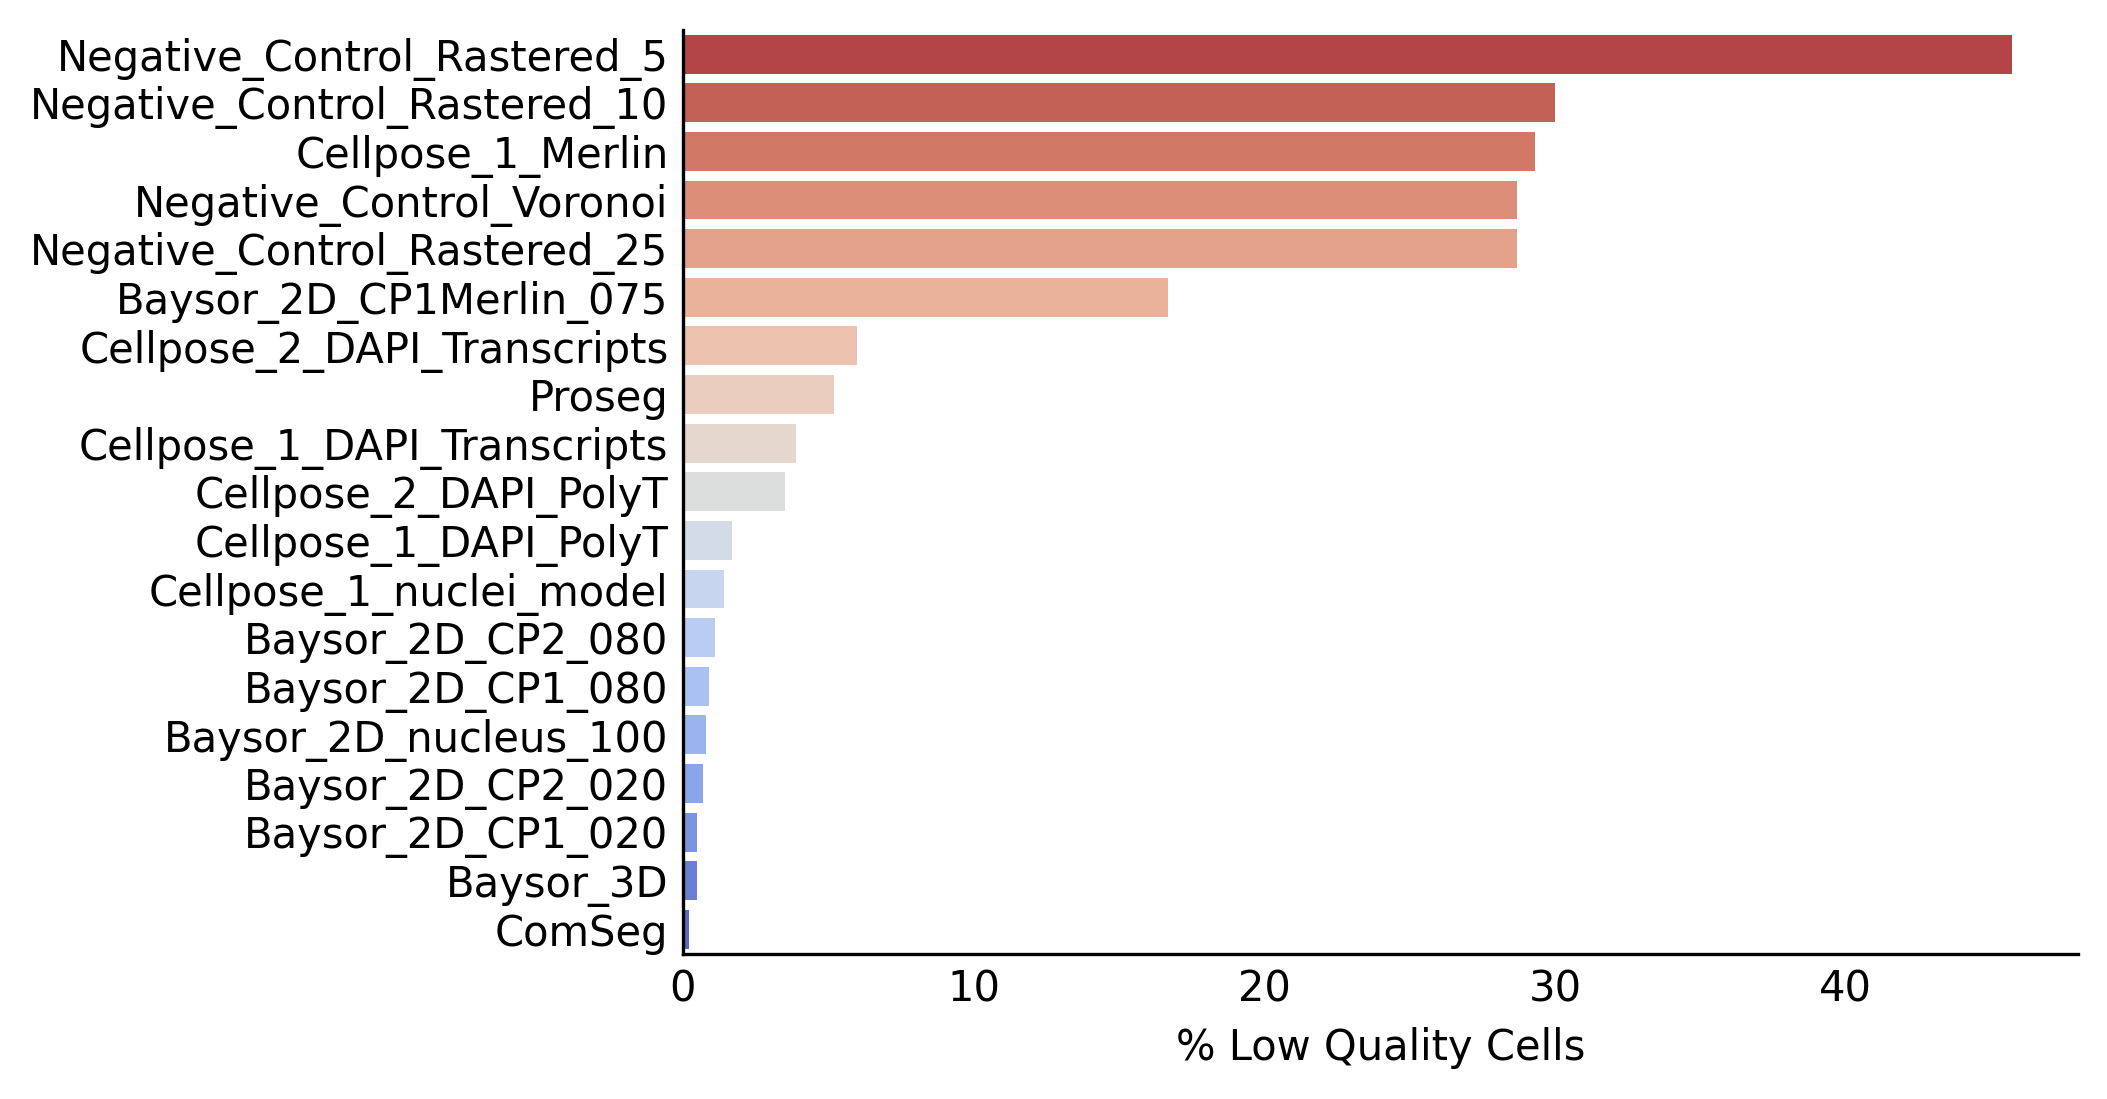

In [128]:
plt.figure(figsize=(6, 4), dpi=300)
sns.barplot(
    x="% Low Quality Cells", y="Dataset", data=df, palette="coolwarm_r", hue="Dataset"
)
plt.ylabel("")
sns.despine()
plt.tick_params(axis="both", which="both", length=0)
plt.show()

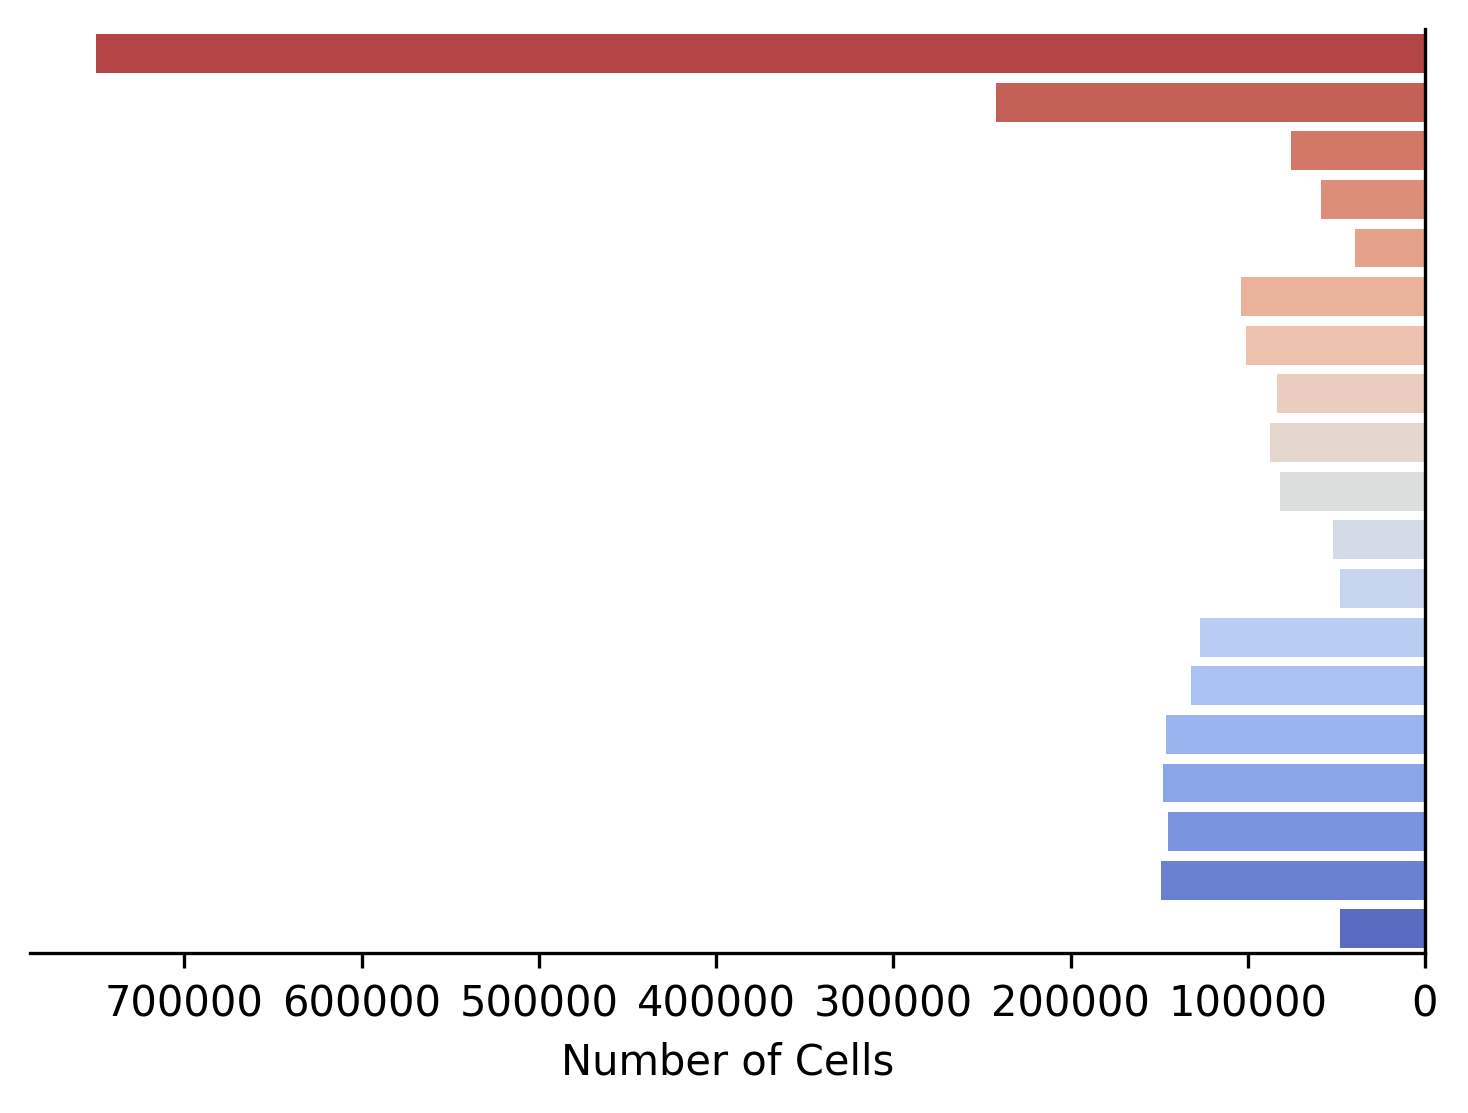

In [129]:
plt.figure(figsize=(6, 4), dpi=300)
ax = sns.barplot(
    x="Number of Cells", y="Dataset", data=df, palette="coolwarm_r", hue="Dataset"
)
ax.invert_xaxis()
plt.ylabel("")
sns.despine(left=True, right=False)
plt.yticks([])
plt.show()

In [63]:
df.dtypes

% Low Quality Cells                       float64
Number of Cells                             int64
Genes per Cell (mean)                       int64
Counts per Cell (mean)                      int64
Cell Area (mean in z=3)                     int64
Cell Transcript Density (mean per um3)    float64
dtype: object

In [62]:
df["Cell Transcript Density (mean per um3)"] = df[
    "Cell Transcript Density (mean per um3)"
].astype(float)
df = df.astype(
    {
        "Number of Cells": int,
        "Genes per Cell (mean)": int,
        "Counts per Cell (mean)": int,
        "Cell Area (mean in z=3)": int,
    }
)

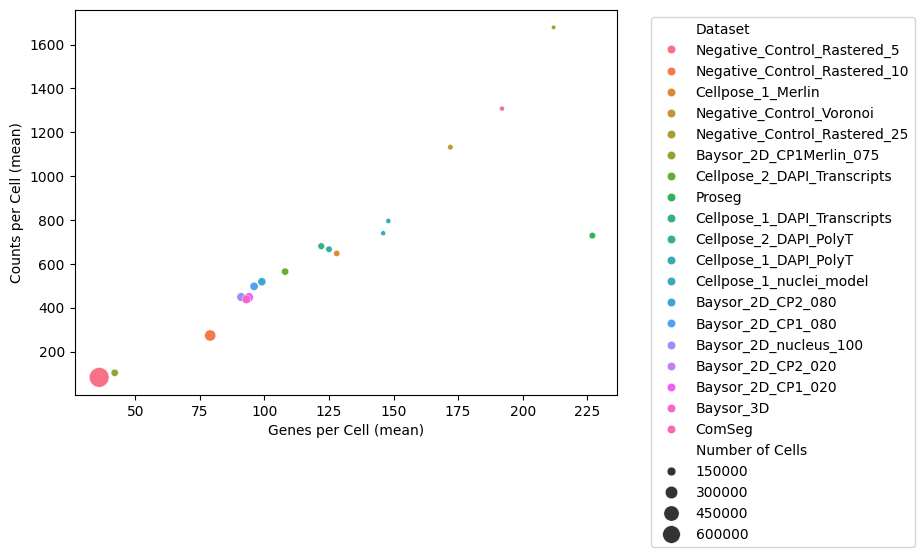

In [67]:
# Scatter plot for Cell Area vs Transcript Density
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="Genes per Cell (mean)",
    y="Counts per Cell (mean)",
    hue="Dataset",
    size="Number of Cells",
    data=df,
    sizes=(10, 200),
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

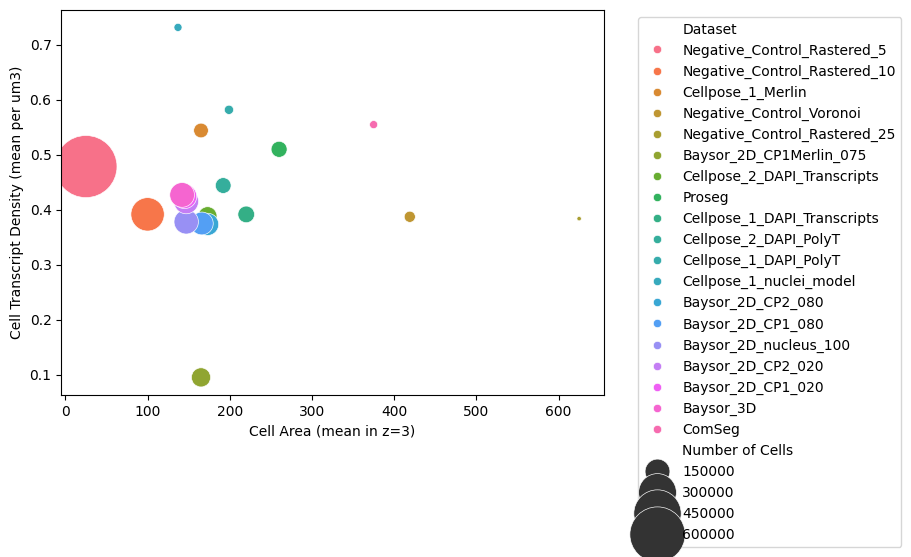

In [123]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="Cell Area (mean in z=3)",
    y="Cell Transcript Density (mean per um3)",
    hue="Dataset",
    size="Number of Cells",
    data=df,
    sizes=(10, 2000),
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

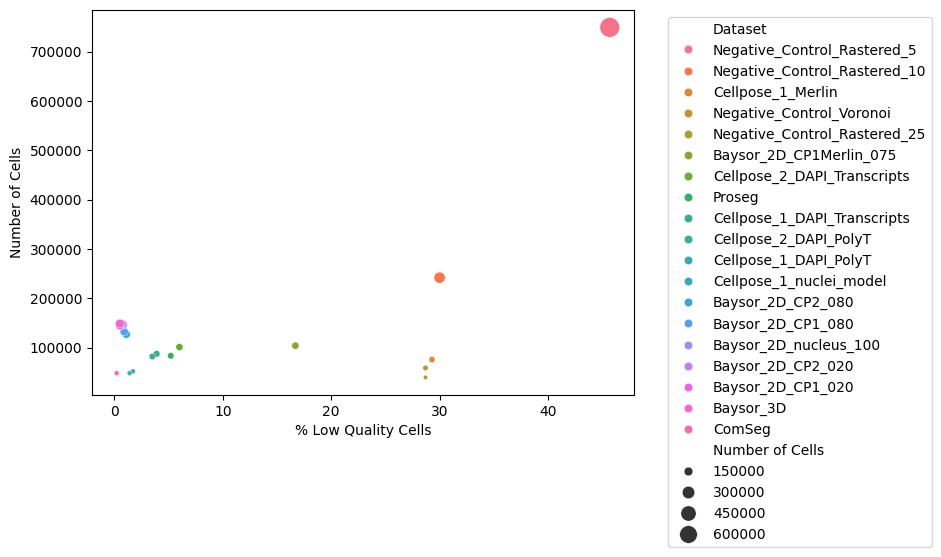

In [70]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="% Low Quality Cells",
    y="Number of Cells",
    hue="Dataset",
    size="Number of Cells",
    data=df,
    sizes=(10, 200),
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Compare 2D area calculation (z=3 only) to 3D volume in default MERLIN output (all z stacks)

In [15]:
# compare to default MERLIN output: 3D volume (all z stacks)
area2d = sdata["adata_Cellpose_1_Merlin"].obs["cell_area_2d"]
area3d = sdata["adata_Cellpose_1_Merlin"].obs["volume"]
area2d.index = area2d.index.astype(int)
area3d.index = area3d.index.astype(int)
area2d.corr(area3d)

np.float64(0.9999999999999999)

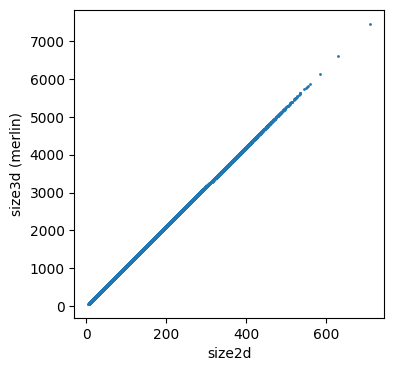

In [16]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    plt.scatter(area2d, area3d, s=1)
    plt.xlabel("size2d")
    plt.ylabel("size3d (merlin)")
    plt.show()

Note: highly correlated

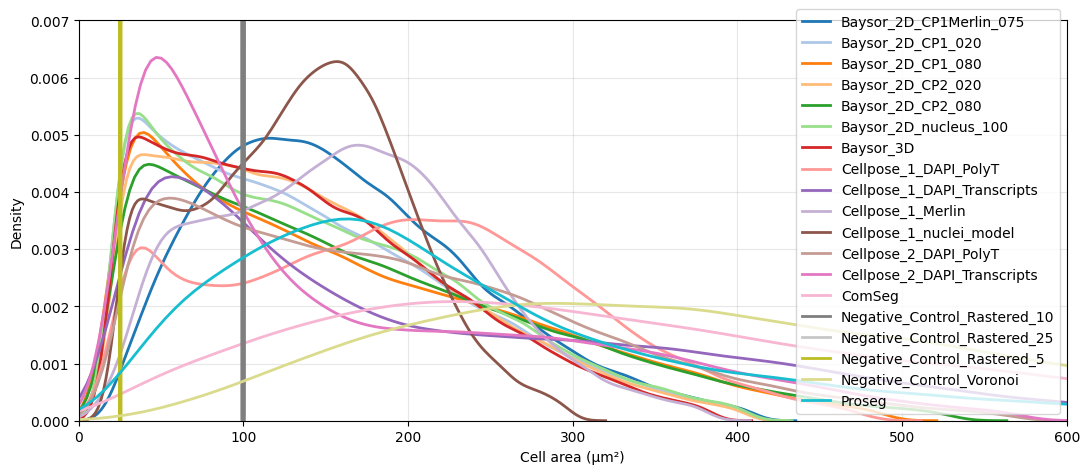

In [17]:
# plot cell_area_2d kde split by method
area_densities = {}
for key, adata in sdata.tables.items():
    if (
        "cell_area_2d" in adata.obs.columns
    ):  # if not key.startswith("adata_Negative") and
        valid_cells = ~adata.obs["cell_outlier"]
        area_densities[key] = adata[valid_cells].obs["cell_area_2d"]

plt.figure(figsize=(11, 5))
colors = sns.color_palette("tab20", n_colors=len(area_densities))
for i, (approach, density) in enumerate(area_densities.items()):
    filtered_data = density[density <= np.percentile(density, 99)]
    sns.kdeplot(
        filtered_data,
        label=approach.replace("adata_", ""),
        color=colors[i],
        linewidth=2,
    )
plt.xlabel("Cell area (µm²)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 600)
plt.ylim(0, 0.007)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# todo: implement
# 3d volume calculation also for 3d
# by iterating over all z planes (pseudo-3D)
# in mean_transcript_densities()
# note: true 3d images are not implemented in sdata -- done in hackathon owkin 03/2025

## Save to disk

In [11]:
adata_keys = list(sdata.tables.keys())
adata_keys

['adata_Baysor_2D_CP1Merlin_075',
 'adata_Baysor_2D_CP1_020',
 'adata_Baysor_2D_CP1_080',
 'adata_Baysor_2D_CP2_020',
 'adata_Baysor_2D_CP2_080',
 'adata_Baysor_2D_nucleus_100',
 'adata_Baysor_3D',
 'adata_Cellpose_1_DAPI_PolyT',
 'adata_Cellpose_1_DAPI_Transcripts',
 'adata_Cellpose_1_Merlin',
 'adata_Cellpose_1_nuclei_model',
 'adata_Cellpose_2_DAPI_PolyT',
 'adata_Cellpose_2_DAPI_Transcripts',
 'adata_ComSeg',
 'adata_Ficture',
 'adata_Negative_Control_Rastered_10',
 'adata_Negative_Control_Rastered_25',
 'adata_Negative_Control_Rastered_5',
 'adata_Negative_Control_Voronoi',
 'adata_Proseg']

In [12]:
len(adata_keys)

20

In [ ]:
# save to disk
# for key in sdata.tables.keys():
#    sdata.write_element(key, overwrite=True)
# cannot overwrite object that is in use
# run workaround instead:

adata_keys_loop = adata_keys[2:7]

for key in adata_keys_loop:
    print(key)
    utils.update_element(sdata, key)

# fails if sdata is accessed by someone else

In [ ]:
# check which adata keys don't have a column containing "cell_outlier" in their obs dataframe
missing_outlier_keys = []
for key in adata_keys:
    if not any("cell_outlier" in col for col in sdata[key].obs.columns):
        missing_outlier_keys.append(key)
missing_outlier_keys

## Transcripts per z plane

In [20]:
# exploratory, not used as metric

In [21]:
from spatialdata.models import PointsModel

points_keys = list(sdata.points.keys())
parsed_points = PointsModel.parse(sdata[points_keys[0]], sort=True)
temp = parsed_points.compute()[["x", "y", "cell_id", "gene", "global_z"]]

In [22]:
temp.head(2)

,x,y,cell_id,gene,global_z
0,7136.4756,2356.3298,1865558700069100825,Igf2,0.0
1,7138.1094,2360.3838,1865558700069100825,Cfp,0.0


In [23]:
temp.global_z.unique()

array([0., 1., 2., 4., 5., 6., 3.])

In [24]:
temp.global_z.value_counts().sort_index()

global_z
0.0    11244109
1.0    11853054
2.0    11840197
3.0    11368572
4.0     9883842
5.0     6853125
6.0     3633456
Name: count, dtype: int64

In [25]:
del temp
del parsed_points

## Pct assigned transcripts

In [26]:
import geopandas as gpd
from spatialdata.models import PointsModel


def count_assigned_transcripts_z3(
    sdata, sdata_transcripts_key, boundaries_to_process=None
):
    """Calculate the percentage of transcripts assigned and not assigned to any cell, across specified boundaries in sdata.

    Parameters:
        sdata: SpatialData object containing transcript data and boundaries
        sdata_transcripts_key (str): Key for transcript data in sdata
        boundaries_to_process (list, optional): List of boundary dataset names to process.
                                               If None, processes all boundaries.

    Returns:
        dict: Dictionary with results for each dataset containing:
            - assigned_count: Number of transcripts assigned to cells
            - unassigned_count: Number of transcripts not assigned to any cell
            - total_count: Total number of transcripts
            - pct_assigned: Percentage of transcripts assigned to cells
    """

    # Load transcripts as GeoDataFrame
    transcripts_df = PointsModel.parse(
        sdata[sdata_transcripts_key], sort=True
    ).compute()[["x", "y", "gene", "transcript_id"]]
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df, geometry=gpd.points_from_xy(transcripts_df.x, transcripts_df.y)
    )
    print(f"Loaded {len(transcripts_gdf)} transcripts")

    results = {}
    # Get boundaries
    boundary_count = 0

    # Filter available boundaries based on boundaries_to_process
    available_boundaries = {
        k: v for k, v in sdata.shapes.items() if k.startswith("boundaries_")
    }
    if boundaries_to_process is not None:
        # Convert dataset names to boundary keys if needed
        boundary_keys = []
        for name in boundaries_to_process:
            if name.startswith("boundaries_"):
                boundary_keys.append(name)
            else:
                boundary_keys.append(f"boundaries_{name}")

        # Filter to only requested boundaries
        available_boundaries = {
            k: v for k, v in available_boundaries.items() if k in boundary_keys
        }
        if not available_boundaries:
            print(
                f"Warning: None of the specified boundaries {boundaries_to_process} were found."
            )

    for boundaries_name, boundaries in available_boundaries.items():
        dataset_name = boundaries_name.replace("boundaries_", "")
        print(f"Processing dataset: {dataset_name}")

        # Check if boundaries is empty or doesn't have geometry column
        if (
            boundaries is None
            or boundaries.empty
            or "geometry" not in boundaries.columns
        ):
            print(
                f"Warning: Empty or invalid geometry data in {boundaries_name}. Skipping dataset."
            )
            continue

        boundary_count += 1

        # Handle ZIndex if present
        if "ZIndex" in boundaries.columns:
            unique_z = boundaries["ZIndex"].unique()
            if len(unique_z) == 1:
                zindex_0 = unique_z[0]
                print(
                    f"Only one z-plane detected for {dataset_name}. Using zindex {zindex_0}."
                )
                boundaries = boundaries[boundaries["ZIndex"] == zindex_0]
            else:
                print(
                    f"Multiple z-planes detected for {dataset_name}. Using all planes."
                )

        try:
            # Create union of all boundary polygons to prevent overlaps and thus duplications in join below
            boundaries_unified = gpd.GeoDataFrame(
                geometry=[boundaries["geometry"].union_all(method="unary")]
            )
            assert boundaries_unified.shape == (1, 1)

            # Spatial point-in-polygon join with rtree index for speed
            joined = gpd.sjoin(
                transcripts_gdf, boundaries_unified, how="left", predicate="within"
            )

            assigned = joined["index_right"].notna().sum()
            unassigned = joined["index_right"].isna().sum()
            assert len(joined) == len(transcripts_gdf) == assigned + unassigned, (
                "Join count mismatch"
            )

            total = len(transcripts_gdf)
            results[dataset_name] = {
                "assigned_count": assigned,
                "unassigned_count": unassigned,
                "total_count": total,
                "pct_assigned": round((assigned / total) * 100, 2),
            }
            print(
                f"Results for {dataset_name}: {assigned}/{total} transcripts assigned ({results[dataset_name]['pct_assigned']}%)"
            )
        except Exception as e:
            print(f"Error processing {dataset_name}: {str(e)}")

    if boundary_count == 0:
        print(
            "No boundary datasets found. Check that boundary data exists with 'boundaries_' prefix"
        )
    else:
        print(f"Processed {boundary_count} boundary datasets")

    return results

In [23]:
control_keys = [k for k in sdata.shapes.keys() if "Negative_Control" in k]
control_keys

['boundaries_Negative_Control_Rastered_10',
 'boundaries_Negative_Control_Rastered_20',
 'boundaries_Negative_Control_Rastered_50',
 'boundaries_Negative_Control_Voronoi']

In [27]:
ass_transc = count_assigned_transcripts_z3(
    sdata,
    sdata_transcripts_key=next(iter(sdata.points.keys())),
    boundaries_to_process=control_keys,
)

Loaded 66676355 transcripts
Processing dataset: Negative_Control_Rastered_10
Results for Negative_Control_Rastered_10: 66676355/66676355 transcripts assigned (100.0%)
Processing dataset: Negative_Control_Rastered_20
Results for Negative_Control_Rastered_20: 66676355/66676355 transcripts assigned (100.0%)
Processing dataset: Negative_Control_Rastered_50
Results for Negative_Control_Rastered_50: 66676355/66676355 transcripts assigned (100.0%)
Processing dataset: Negative_Control_Voronoi
Results for Negative_Control_Voronoi: 66676352/66676355 transcripts assigned (100.0%)
Processed 4 boundary datasets


In [ ]:
ass_transc = count_assigned_transcripts_z3(
    sdata,
    sdata_transcripts_key=next(iter(sdata.points.keys())),
    boundaries_to_process=None,  # loop over all boundaries
)

In [38]:
import pandas as pd

results_df = pd.DataFrame.from_dict(ass_transc, orient="index")
results_df.to_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "metrics",
        date_var + "_assigned_transcripts.csv",
    )
)

In [132]:
date_set = "20250319"
ta = pd.read_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "metrics",
        date_set + "_assigned_transcripts.csv",
    ),
    index_col=0,
)
ta = ta.rename(columns={"Unnamed: 0": "dataset"})
ta

,dataset,assigned_count,unassigned_count,total_count,pct_assigned
0,Baysor_2D_CP1Merlin_075,58691283,7985072,66676355,88.02
1,Baysor_2D_CP1_020,62914674,3761681,66676355,94.36
2,Baysor_2D_CP1_080,64016809,2659546,66676355,96.01
3,Baysor_2D_CP2_020,63486436,3189919,66676355,95.22
4,Baysor_2D_CP2_080,64269019,2407336,66676355,96.39
5,Baysor_2D_nucleus_100,63672125,3004230,66676355,95.49
6,Baysor_3D,63062131,3614224,66676355,94.58
7,Cellpose_1_DAPI_PolyT,41086771,25589584,66676355,61.62
8,Cellpose_1_DAPI_Transcripts,59367235,7309120,66676355,89.04
9,Cellpose_1_Merlin,49389857,17286498,66676355,74.07


In [133]:
ta["dataset"] = ta["dataset"].replace(
    {
        "Negative_Control_": "",
        "Transcripts": "Transc",
        "Baysor": "Bay",
        "Cellpose": "CP",
        "nuclei": "nuc",
        "nucleus": "nuc",
        "Merlin": "Mer",
    },
    regex=True,
)

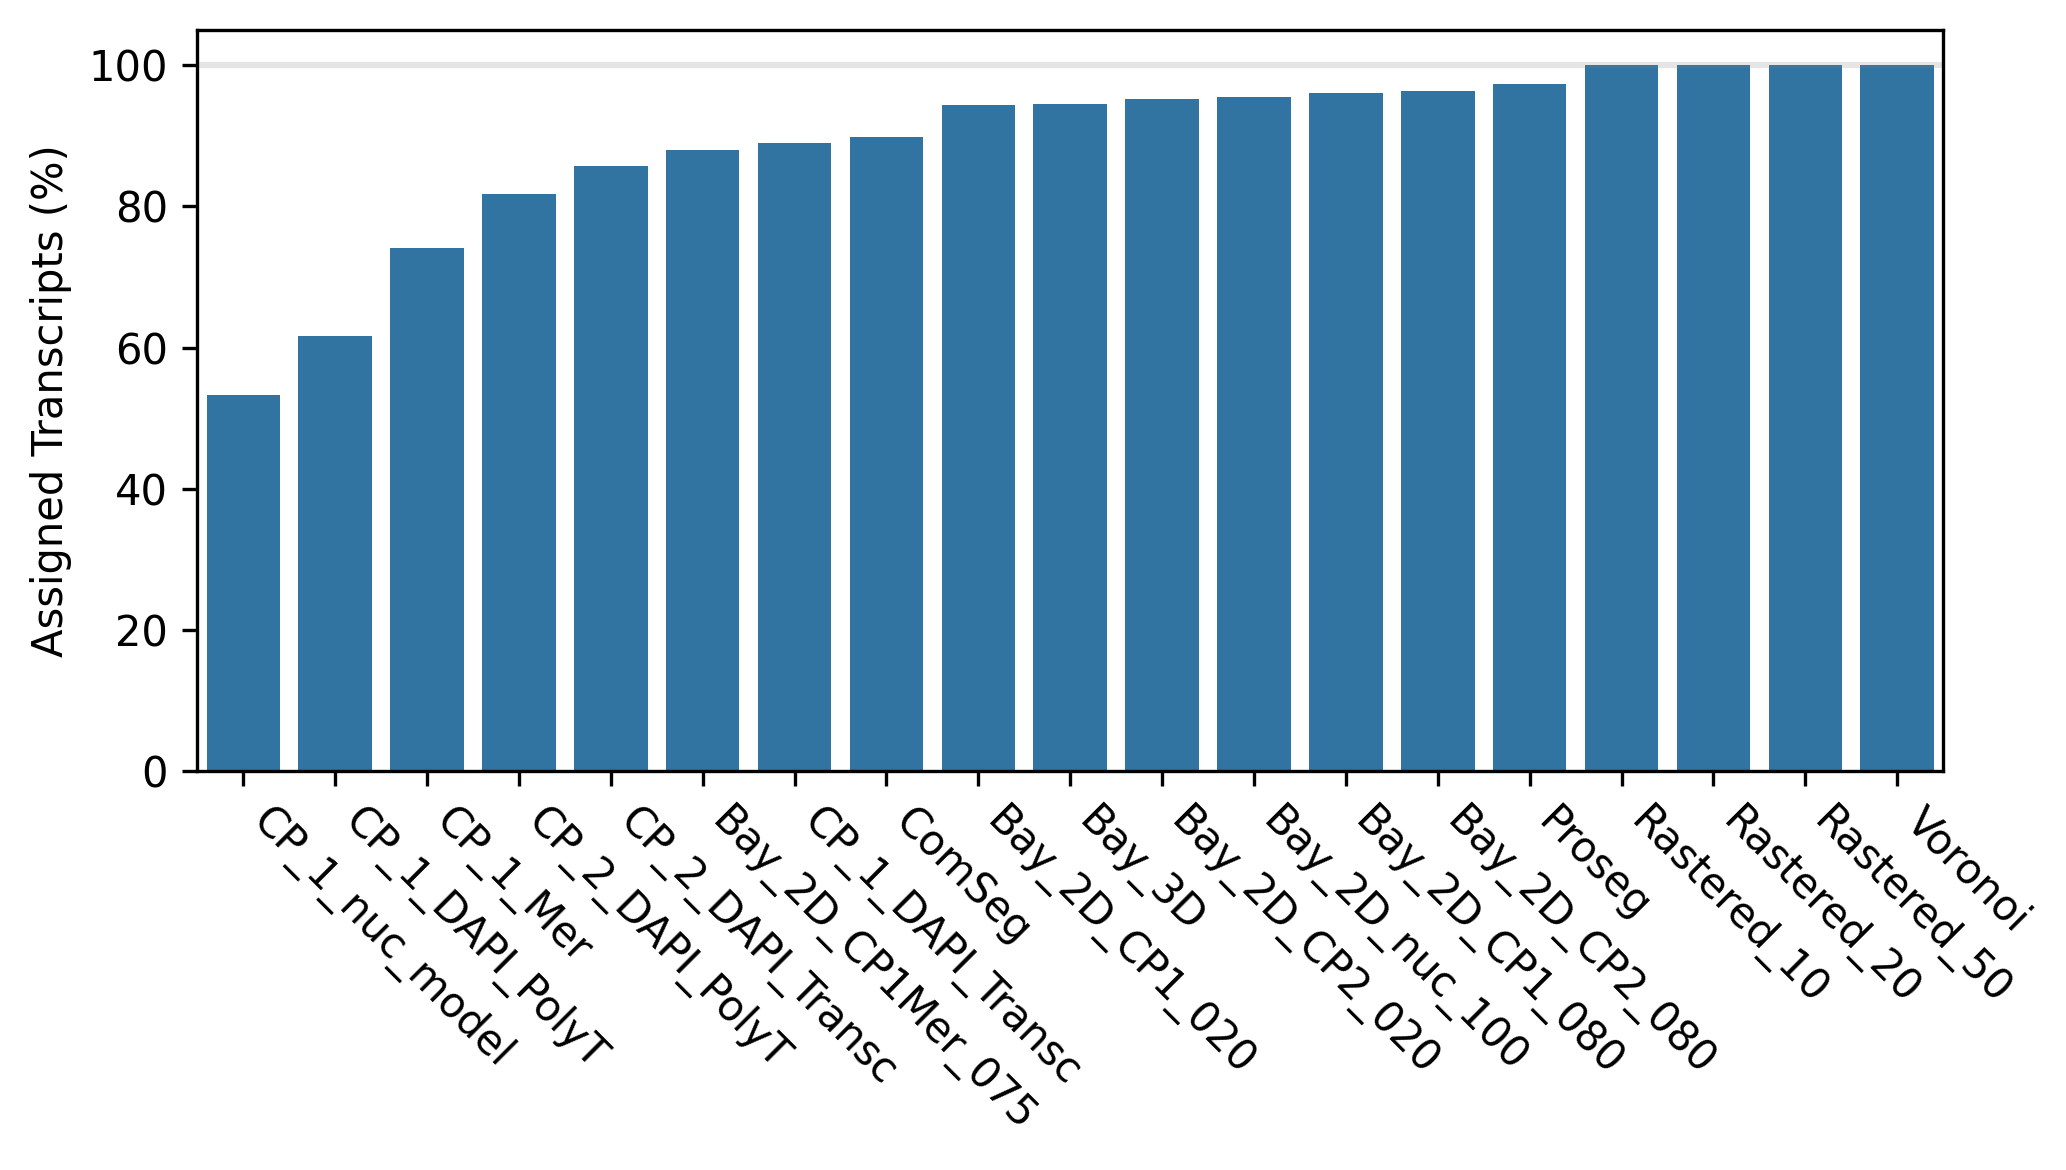

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = ta.sort_values(by="pct_assigned")

plt.figure(figsize=(7, 4), dpi=300)
ax = sns.barplot(x="dataset", y="pct_assigned", data=plot_data)
ax.axhline(y=100, color="grey", linestyle="-", alpha=0.2)
plt.ylabel("Assigned Transcripts (%)")
plt.xlabel("")
plt.xticks(rotation=-45, ha="left")
plt.tight_layout()
plt.show()

## Top segmented genes

Ranks genes based on the proportion of unsegmented vs segmented transcripts

In [28]:
import pandas as pd
from spatialdata.models import PointsModel


def top_unsegmented_genes_spatial(transcripts_gdf, boundaries, gene_identifier="gene"):
    """Ranks genes based on the proportion of unsegmented vs segmented transcripts using spatial boundaries.

    Parameters:
        transcripts_gdf: GeoDataFrame with transcript data
        boundaries: GeoDataFrame with boundary data
        gene_identifier (str, optional): The column name for gene identifiers (default is "gene")

    Returns:
        dict: Dictionary with gene-level results for the boundary dataset containing:
            - A pandas DataFrame with gene-level segmentation statistics
            - Summary statistics about overall transcript assignment
    """
    # Check if boundaries has valid geometry
    if boundaries is None or boundaries.empty or "geometry" not in boundaries.columns:
        raise ValueError("Empty or invalid geometry data in boundaries")

    # Filter by ZIndex if present
    if "ZIndex" in boundaries.columns:
        unique_z = boundaries["ZIndex"].unique()
        if len(unique_z) == 1:
            zindex_0 = unique_z[0]
            print(f"Single z-plane detected. Using zindex {zindex_0}.")
            boundaries = boundaries[boundaries["ZIndex"] == zindex_0]

    # Create unified boundaries to prevent overlaps
    boundaries_unified = gpd.GeoDataFrame(
        geometry=[boundaries["geometry"].union_all(method="unary")]
    )

    # Spatial join to assign transcripts to cells
    joined = gpd.sjoin(
        transcripts_gdf, boundaries_unified, how="left", predicate="within"
    )

    # Determine segmented vs unsegmented transcripts
    joined["segmented"] = joined["index_right"].notna()

    # Calculate gene-level statistics
    segmented_counts = joined[joined["segmented"]][gene_identifier].value_counts()
    unsegmented_counts = joined[~joined["segmented"]][gene_identifier].value_counts()

    # Create and format results DataFrame
    gene_counts = pd.DataFrame(
        {"segmented_count": segmented_counts, "unsegmented_count": unsegmented_counts}
    ).fillna(0)

    gene_counts["total_count"] = gene_counts.sum(axis=1)
    gene_counts["unsegmented_proportion"] = (
        gene_counts["unsegmented_count"] / gene_counts["total_count"]
    ).round(2)
    gene_counts = gene_counts.sort_values("unsegmented_proportion", ascending=False)

    # Calculate overall statistics
    assigned = joined["segmented"].sum()
    unassigned = (~joined["segmented"]).sum()
    total = len(joined)

    summary = {
        "assigned_count": int(assigned),
        "unassigned_count": int(unassigned),
        "total_count": total,
        "pct_assigned": round((assigned / total) * 100, 2),
    }

    return {"gene_results": gene_counts, "summary": summary}


def analyze_gene_segmentation_across_boundaries(
    sdata, sdata_transcripts_key, boundaries_to_process=None, gene_identifier="gene"
):
    """Analyze gene segmentation across multiple boundary datasets.

    Parameters:
        sdata: SpatialData object containing transcript data and boundaries
        sdata_transcripts_key (str): Key for transcript data in sdata
        boundaries_to_process (list, optional): List of boundary dataset names to process.
                                               If None, processes all boundaries.
        gene_identifier (str, optional): The column name for gene identifiers (default is "gene")

    Returns:
        dict: Dictionary with results for each dataset
    """
    # Load transcripts as GeoDataFrame - ONLY ONCE
    transcripts_df = PointsModel.parse(
        sdata[sdata_transcripts_key], sort=True
    ).compute()[["x", "y", gene_identifier]]
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df, geometry=gpd.points_from_xy(transcripts_df.x, transcripts_df.y)
    )
    print(f"Loaded {len(transcripts_gdf)} transcripts")

    # Filter available boundaries
    available_boundaries = {
        k: v for k, v in sdata.shapes.items() if k.startswith("boundaries_")
    }
    if boundaries_to_process is not None:
        boundary_keys = [
            name if name.startswith("boundaries_") else f"boundaries_{name}"
            for name in boundaries_to_process
        ]
        available_boundaries = {
            k: v for k, v in available_boundaries.items() if k in boundary_keys
        }

    if not available_boundaries:
        print("No valid boundary datasets found.")
        return {}

    results = {}
    for boundary_key in available_boundaries.keys():
        try:
            dataset_name = boundary_key.replace("boundaries_", "")
            print(f"Processing dataset: {dataset_name}")

            result = top_unsegmented_genes_spatial(
                transcripts_gdf, sdata.shapes[boundary_key], gene_identifier
            )

            # Add dataset-specific summary print
            assigned = result["summary"]["assigned_count"]
            total = result["summary"]["total_count"]
            pct_assigned = result["summary"]["pct_assigned"]
            print(
                f"Results for {dataset_name}: {assigned}/{total} transcripts assigned ({pct_assigned}%)"
            )
            print(
                f"Found {len(result['gene_results'])} genes with varying segmentation rates"
            )

            results[dataset_name] = result
        except Exception as e:
            print(f"Error processing {boundary_key}: {str(e)}")

    return results

In [29]:
res_all = analyze_gene_segmentation_across_boundaries(
    sdata,
    sdata_transcripts_key=next(iter(sdata.points.keys())),
    boundaries_to_process=None,
    gene_identifier="gene",
)

Loaded 66676355 transcripts
Processing dataset: Baysor_2D_CP1Merlin_075
Results for Baysor_2D_CP1Merlin_075: 58691283/66676355 transcripts assigned (88.02%)
Found 550 genes with varying segmentation rates
Processing dataset: Baysor_2D_CP1_020
Results for Baysor_2D_CP1_020: 62914674/66676355 transcripts assigned (94.36%)
Found 550 genes with varying segmentation rates
Processing dataset: Baysor_2D_CP1_080
Results for Baysor_2D_CP1_080: 64016809/66676355 transcripts assigned (96.01%)
Found 550 genes with varying segmentation rates
Processing dataset: Baysor_2D_CP2_020
Results for Baysor_2D_CP2_020: 63486436/66676355 transcripts assigned (95.22%)
Found 550 genes with varying segmentation rates
Processing dataset: Baysor_2D_CP2_080
Results for Baysor_2D_CP2_080: 64269019/66676355 transcripts assigned (96.39%)
Found 550 genes with varying segmentation rates
Processing dataset: Baysor_2D_nucleus_100
Results for Baysor_2D_nucleus_100: 63672125/66676355 transcripts assigned (95.49%)
Found 550 

In [36]:
all_gene_results = []
for dataset, result in res_all.items():
    df = result["gene_results"].copy()
    df["dataset"] = dataset
    all_gene_results.append(df)
final_df = pd.concat(all_gene_results).reset_index().rename(columns={"index": "gene"})
final_df.to_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "metrics",
        date_var + "_assigned_transcripts_by_gene.csv",
    )
)

In [11]:
date_set = "20250319"
final_df = pd.read_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "metrics",
        date_set + "_assigned_transcripts_by_gene.csv",
    )
)

In [12]:
final_df.head(2)

,Unnamed: 0,gene,segmented_count,unsegmented_count,total_count,unsegmented_proportion,dataset
0,0,Jph3,219340,62335,281675,0.22,Baysor_2D_CP1Merlin_075
1,1,Apoe,916768,262039,1178807,0.22,Baysor_2D_CP1Merlin_075


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_gene_heatmaps(final_df, multi_plot=True):
    datasets = final_df["dataset"].unique()
    num_datasets = len(datasets)

    if multi_plot:
        fig, axes = plt.subplots(
            nrows=num_datasets, figsize=(2.5, 2.75 * num_datasets), dpi=300
        )
        if num_datasets == 1:
            axes = [axes]  # Ensure iterable if only one dataset

    for i, dataset in enumerate(datasets):
        df = final_df[final_df["dataset"] == dataset]
        df = df[~df["gene"].str.contains("Blank")]
        df = df.sort_values("unsegmented_proportion", ascending=False)
        top_genes = df.head(5)
        bottom_genes = df.tail(5)

        display_genes = pd.concat([top_genes, bottom_genes])
        matrix = pd.DataFrame(
            ((1 - display_genes["unsegmented_proportion"]) * 100).astype(int)
        )

        if multi_plot:
            ax = axes[i]
        else:
            fig, ax = plt.subplots(figsize=(2, 2.75), dpi=300)

        sns.heatmap(
            matrix,
            cmap="Blues",
            annot=True,
            cbar_kws={"label": "% segmented in cells"},
            ax=ax,
            vmin=0,
            vmax=100,
            fmt="d",
        )
        ax.axhline(y=5, color="black", linewidth=1)
        ax.set_title(f"{dataset}", fontsize=10)
        ax.tick_params(axis="x", which="both", bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels(display_genes["gene"], rotation=0)

        if not multi_plot:
            plt.show()

    if multi_plot:
        plt.tight_layout()
        plt.show()

In [ ]:
plot_gene_heatmaps(final_df, multi_plot=True)

In [146]:
adata.obs["cell_type_final"].value_counts()

cell_type_final
Undefined           20329
Astrocytes          10591
Oligodendrocytes    10107
Neurons-Glut         9318
Neurons-Immature     6999
Neurons-Gaba         5767
ECs                  5300
Neurons-Other        4705
Microglia            3329
OPCs                 1977
nan                  1854
Pericytes            1275
SMCs                  958
VLMCs                 876
Choroid Plexus        637
Neurons-Dopa          387
BAMs                  313
Name: count, dtype: int64

## cell type distribution

In [148]:
adata_keys = list(sdata.tables.keys())
adata_keys

['adata_Baysor_2D_CP1Merlin_075',
 'adata_Baysor_2D_CP1_020',
 'adata_Baysor_2D_CP1_080',
 'adata_Baysor_2D_CP2_020',
 'adata_Baysor_2D_CP2_080',
 'adata_Baysor_2D_nucleus_100',
 'adata_Baysor_3D',
 'adata_Cellpose_1_DAPI_PolyT',
 'adata_Cellpose_1_DAPI_Transcripts',
 'adata_Cellpose_1_Merlin',
 'adata_Cellpose_1_nuclei_model',
 'adata_Cellpose_2_DAPI_PolyT',
 'adata_Cellpose_2_DAPI_Transcripts',
 'adata_ComSeg',
 'adata_Ficture',
 'adata_Negative_Control_Rastered_10',
 'adata_Negative_Control_Rastered_25',
 'adata_Negative_Control_Rastered_5',
 'adata_Negative_Control_Voronoi',
 'adata_Proseg']

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Function to plot cell type distributions
def plot_cell_type_distributions(sdata, filtered_keys):
    # Create a dictionary to store all distributions
    all_distributions = {}

    # Process each dataset
    for key in filtered_keys:
        try:
            print("Processing " + key)
            adata = sdata[key].copy()

            valid_cells = ~adata.obs["cell_outlier"]
            adata_filtered = adata[valid_cells]

            # Get cell type distribution
            if "cell_type_final" in adata_filtered.obs.columns:
                cell_counts = adata_filtered.obs["cell_type_final"].value_counts()
                # Remove nan entries
                if pd.isna(cell_counts.index).any():
                    cell_counts = cell_counts.drop(index=np.nan)
                # Use raw counts instead of percentages
                all_distributions[key] = cell_counts
            else:
                print(f"No 'cell_type_final' column found in {key}")
        except Exception as e:
            print(f"Error processing {key}: {e}")

    # Combine all distributions into a single DataFrame
    df = pd.DataFrame(all_distributions).fillna(0)

    # Use the same order as in the legend
    legend_order = [
        "ECs",
        "Pericytes",
        "SMCs",
        "VLMCs",
        "Ependymal",
        "Choroid Plexus",
        "Astrocytes",
        "Oligodendrocytes",
        "OPCs",
        "Microglia",
        "BAMs",
        "Immune-Other",
        "Neurons-Gaba",
        "Neurons-Glut",
        "Neurons-Dopa",
        "Neurons-Immature",
        "Neurons-Other",
        "OECs",
        "Undefined",
    ]

    # Reindex the dataframe to match the legend order
    # Only include cell types that exist in the data
    existing_types = [t for t in legend_order if t in df.index]
    df = df.reindex(existing_types)

    # Create a stacked bar plot with wider bars (width=0.7 instead of default 0.5)
    fig, ax = plt.subplots(figsize=(9, 7), dpi=300)

    # Define colors matching the legend image
    color_map = {
        "ECs": "#2166ac",  # Blue
        "Pericytes": "#f08a24",  # Orange
        "SMCs": "#469457",  # Green
        "VLMCs": "#d6604d",  # Red
        "Ependymal": "#8a4fff",  # Purple
        "Choroid Plexus": "#8c6548",  # Brown
        "Astrocytes": "#c15dcf",  # Pink/Purple
        "Oligodendrocytes": "#aaab56",  # Olive
        "OPCs": "#41b7c4",  # Teal
        "Microglia": "#b3cde3",  # Light blue
        "BAMs": "#f4bf78",  # Light orange
        "Immune-Other": "#a6d96a",  # Light green
        "Neurons-Gaba": "#f98e8e",  # Light red/pink
        "Neurons-Glut": "#bebada",  # Light purple
        "Neurons-Dopa": "#c19a89",  # Light brown
        "Neurons-Immature": "#ffcccb",  # Light pink
        "Neurons-Other": "#e5e37c",  # Light yellow
        "OECs": "#7ecece",  # Light teal
        "Undefined": "#8c4646",  # Dark red/brown
    }

    # Get colors for each cell type, defaulting to a neutral color if not in our map
    colors = [color_map.get(cell_type, "#cccccc") for cell_type in df.index]

    # Plot the percentage stacked bar chart
    df_pct = df.div(df.sum(axis=0), axis=1) * 100
    df_pct.T.plot(kind="bar", stacked=True, ax=ax, color=colors, width=0.8, zorder=0)

    # Customize the plot
    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel("% of Cells", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()

    return fig, all_distributions

Processing adata_Baysor_2D_CP1Merlin_075
Processing adata_Baysor_2D_CP1_020
Processing adata_Baysor_2D_CP1_080
Processing adata_Baysor_2D_CP2_020
Processing adata_Baysor_2D_CP2_080
Processing adata_Baysor_2D_nucleus_100
Processing adata_Baysor_3D
Processing adata_Cellpose_1_DAPI_PolyT
Processing adata_Cellpose_1_DAPI_Transcripts
Processing adata_Cellpose_1_Merlin
No 'cell_type_final' column found in adata_Cellpose_1_Merlin
Processing adata_Cellpose_1_nuclei_model
Processing adata_Cellpose_2_DAPI_PolyT
Processing adata_Cellpose_2_DAPI_Transcripts
Processing adata_ComSeg
Processing adata_Ficture
No 'cell_type_final' column found in adata_Ficture
Processing adata_Negative_Control_Rastered_10
Processing adata_Negative_Control_Rastered_25
Processing adata_Negative_Control_Rastered_5
Processing adata_Negative_Control_Voronoi
Processing adata_Proseg


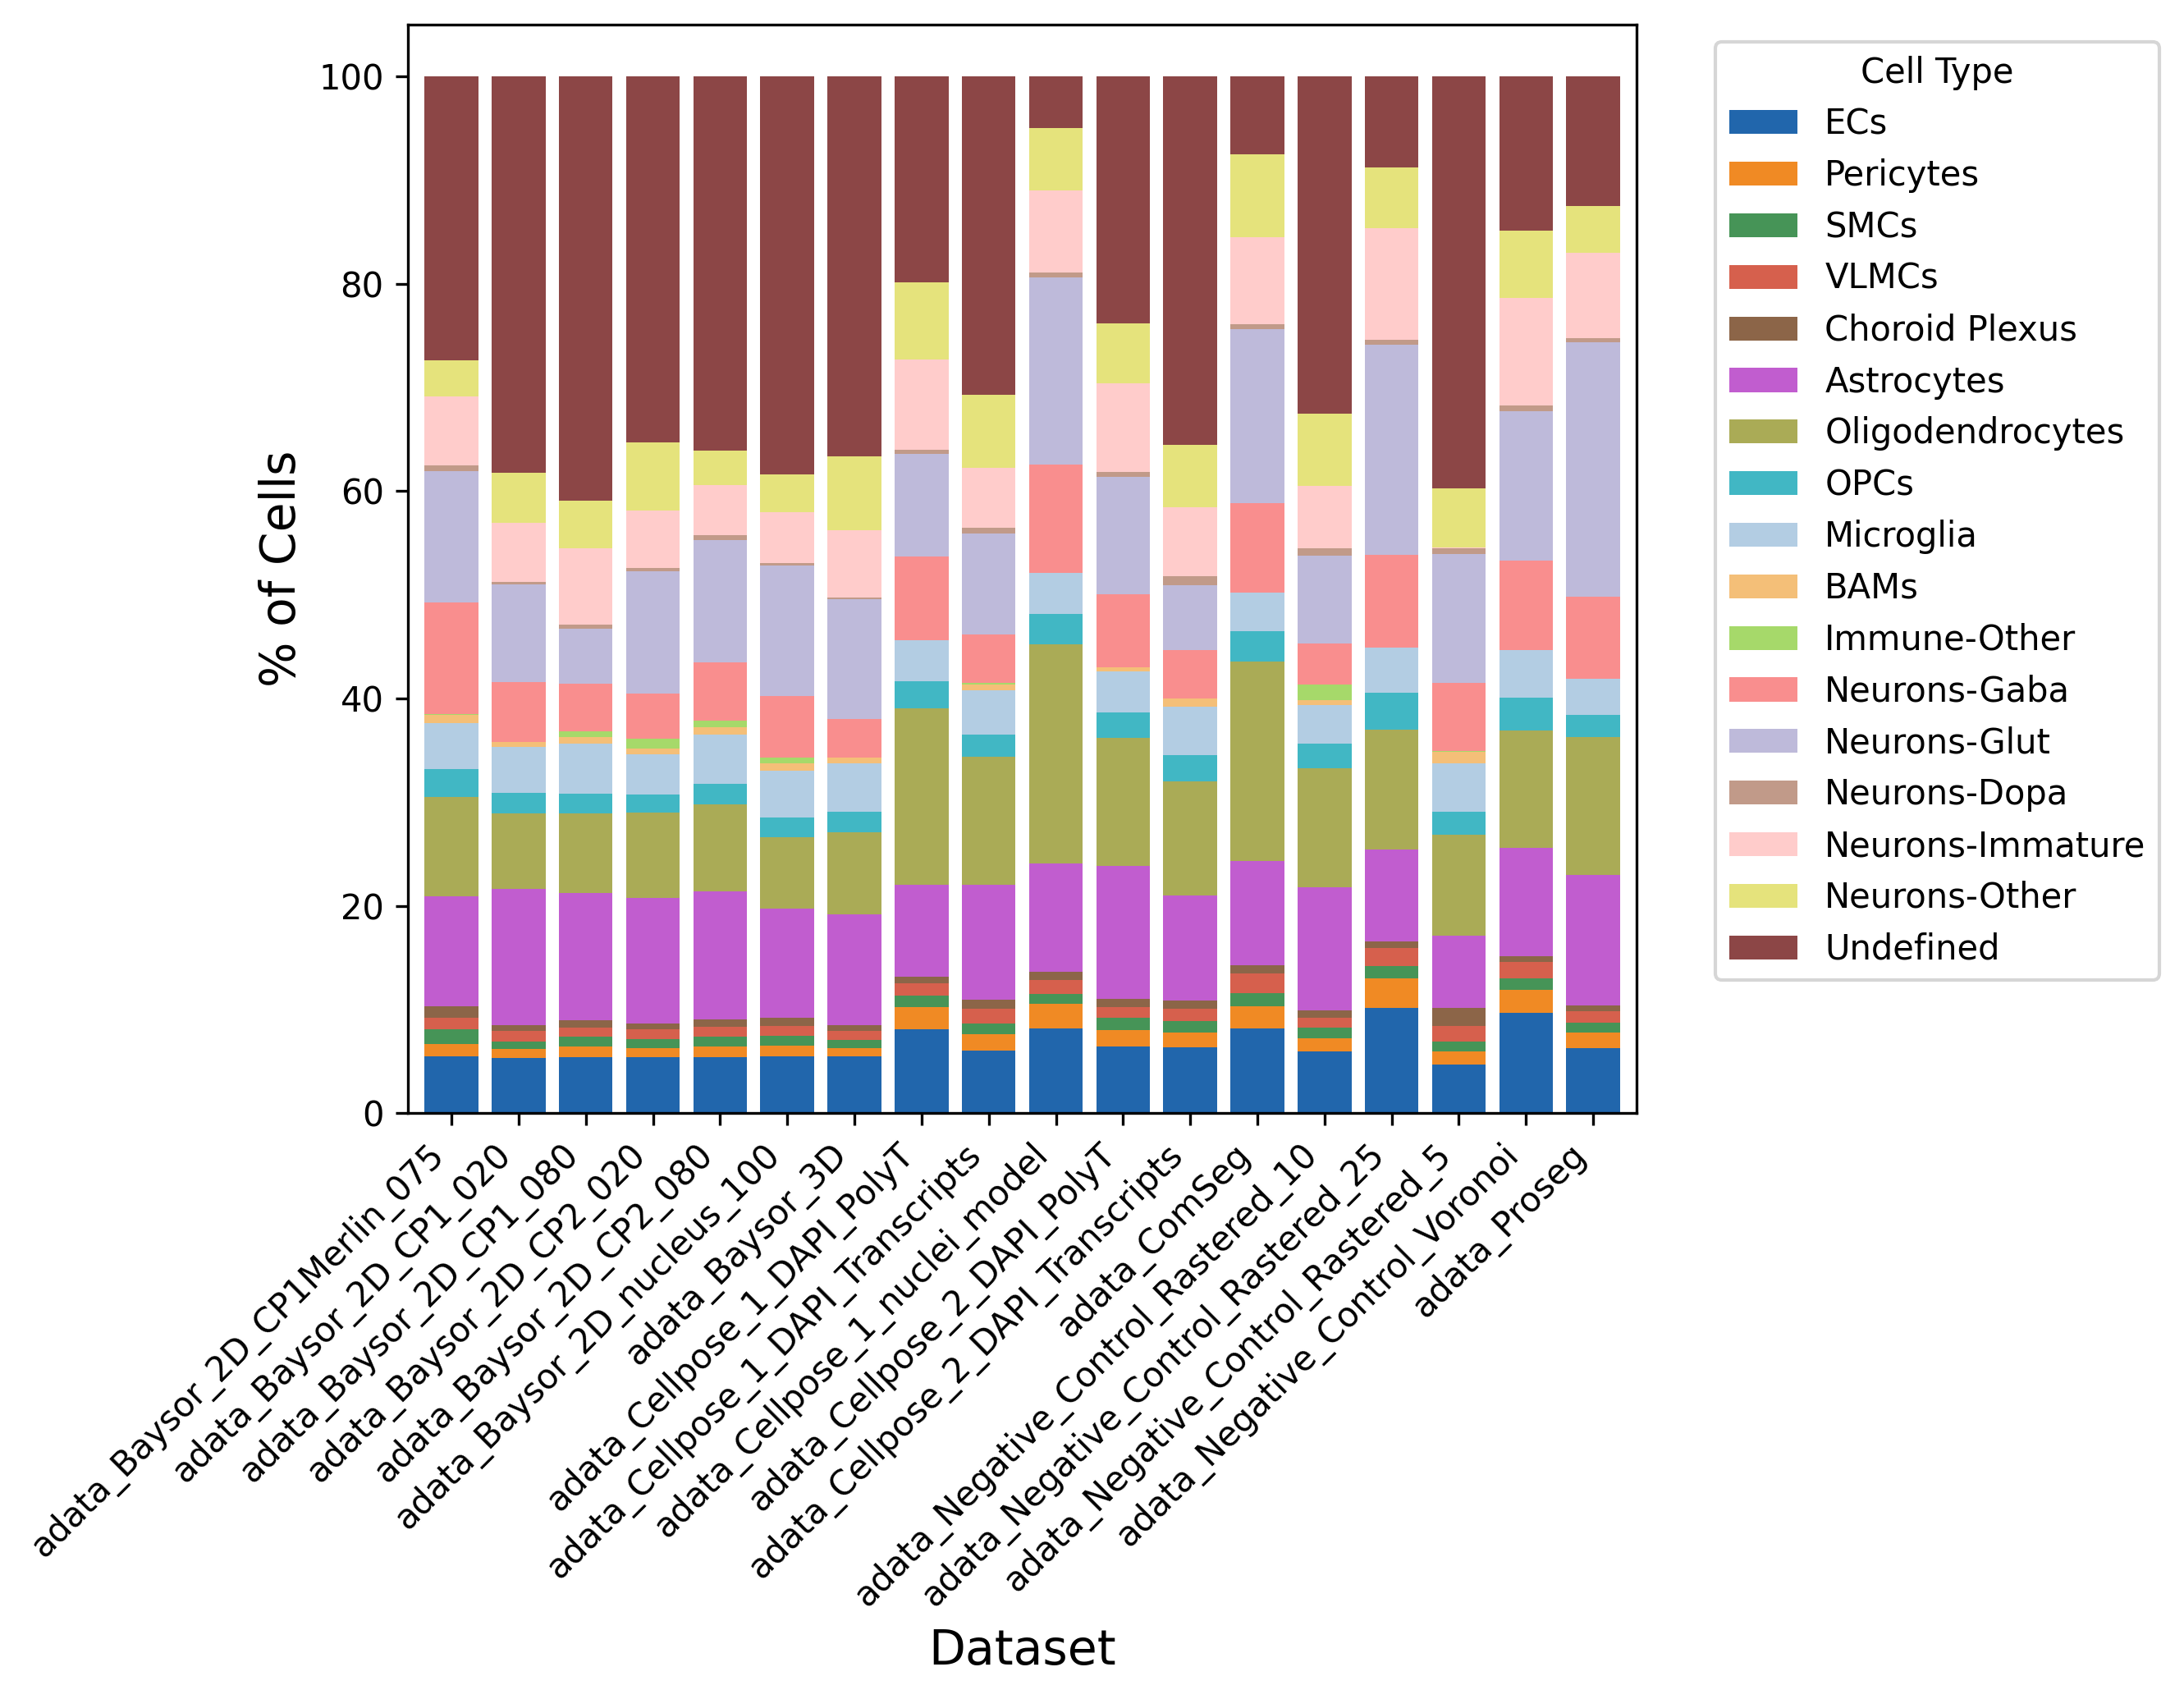

In [211]:
fig, distributions = plot_cell_type_distributions(sdata, adata_keys)
# plt.savefig('cell_type_distributions.png', dpi=300, bbox_inches='tight')
# plt.show()

In [195]:
distributions

{'adata_Baysor_2D_CP1Merlin_075': cell_type_final
 Undefined           28420
 Neurons-Glut        13216
 Neurons-Gaba        11210
 Astrocytes          10995
 Oligodendrocytes     9972
 Neurons-Immature     6951
 ECs                  5728
 Microglia            4616
 Neurons-Other        3622
 OPCs                 2790
 SMCs                 1477
 Pericytes            1192
 Choroid Plexus       1173
 VLMCs                1153
 BAMs                  822
 Neurons-Dopa          520
 Immune-Other           45
 Name: count, dtype: int64,
 'adata_Baysor_2D_CP1_020': cell_type_final
 Undefined           55449
 Astrocytes          19003
 Neurons-Glut        13701
 Oligodendrocytes    10580
 Neurons-Gaba         8366
 Neurons-Immature     8325
 ECs                  7706
 Neurons-Other        7007
 Microglia            6442
 OPCs                 2870
 VLMCs                1453
 Pericytes            1244
 SMCs                 1074
 Choroid Plexus        881
 BAMs                  687
 Neurons-Dopa 

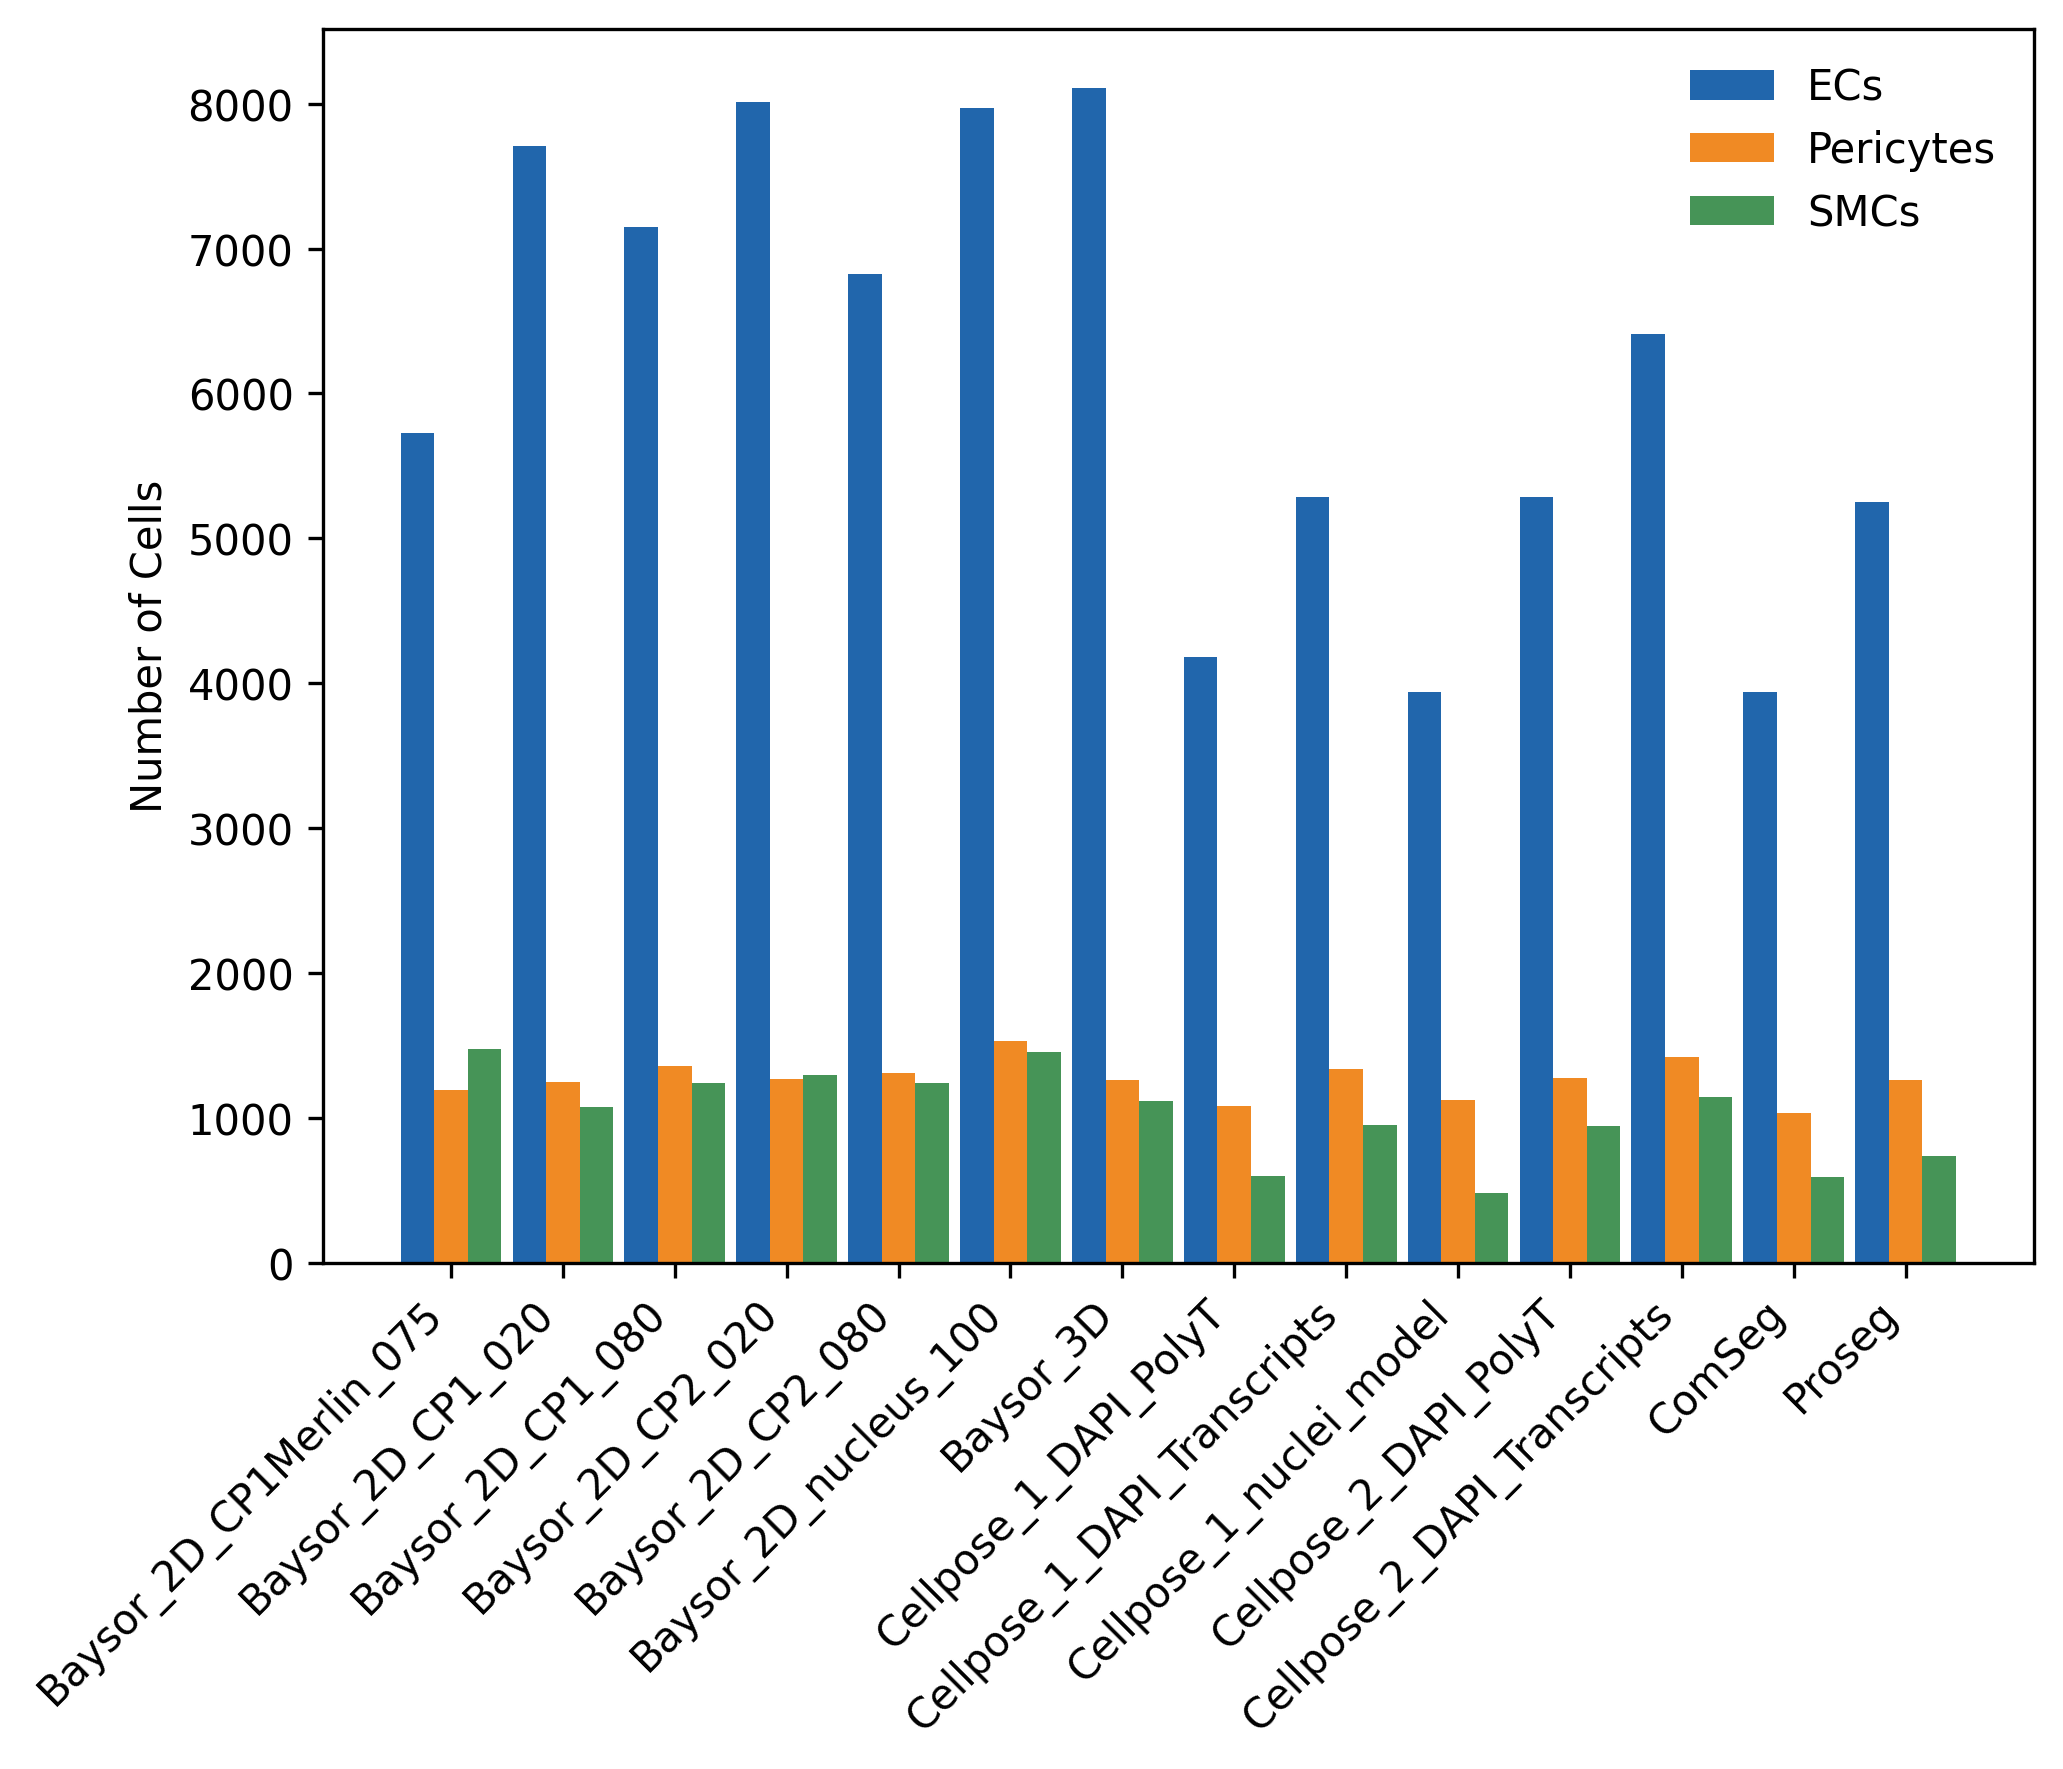

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define vascular cell types
vascular_cells = ["ECs", "Pericytes", "SMCs"]

# Extract vascular cell counts into a DataFrame, excluding negative controls
data = {}
for dataset, counts in distributions.items():
    # Replace "adata_" with "" in dataset names
    clean_name = dataset.replace("adata_", "")

    # Skip datasets starting with "Negative_Control"
    if clean_name.startswith("Negative_Control"):
        continue

    data[clean_name] = {cell: counts.get(cell, 0) for cell in vascular_cells}

df = pd.DataFrame(data).T

# Plot setup
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
x = np.arange(len(df))
width = 0.3
colors = {"ECs": "#2166ac", "Pericytes": "#f08a24", "SMCs": "#469457"}

# Plot bars for each cell type
for i, cell in enumerate(vascular_cells):
    ax.bar(x + (i - 1) * width, df[cell], width, label=cell, color=colors[cell])

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45, ha="right")
ax.set_ylabel("Number of Cells")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

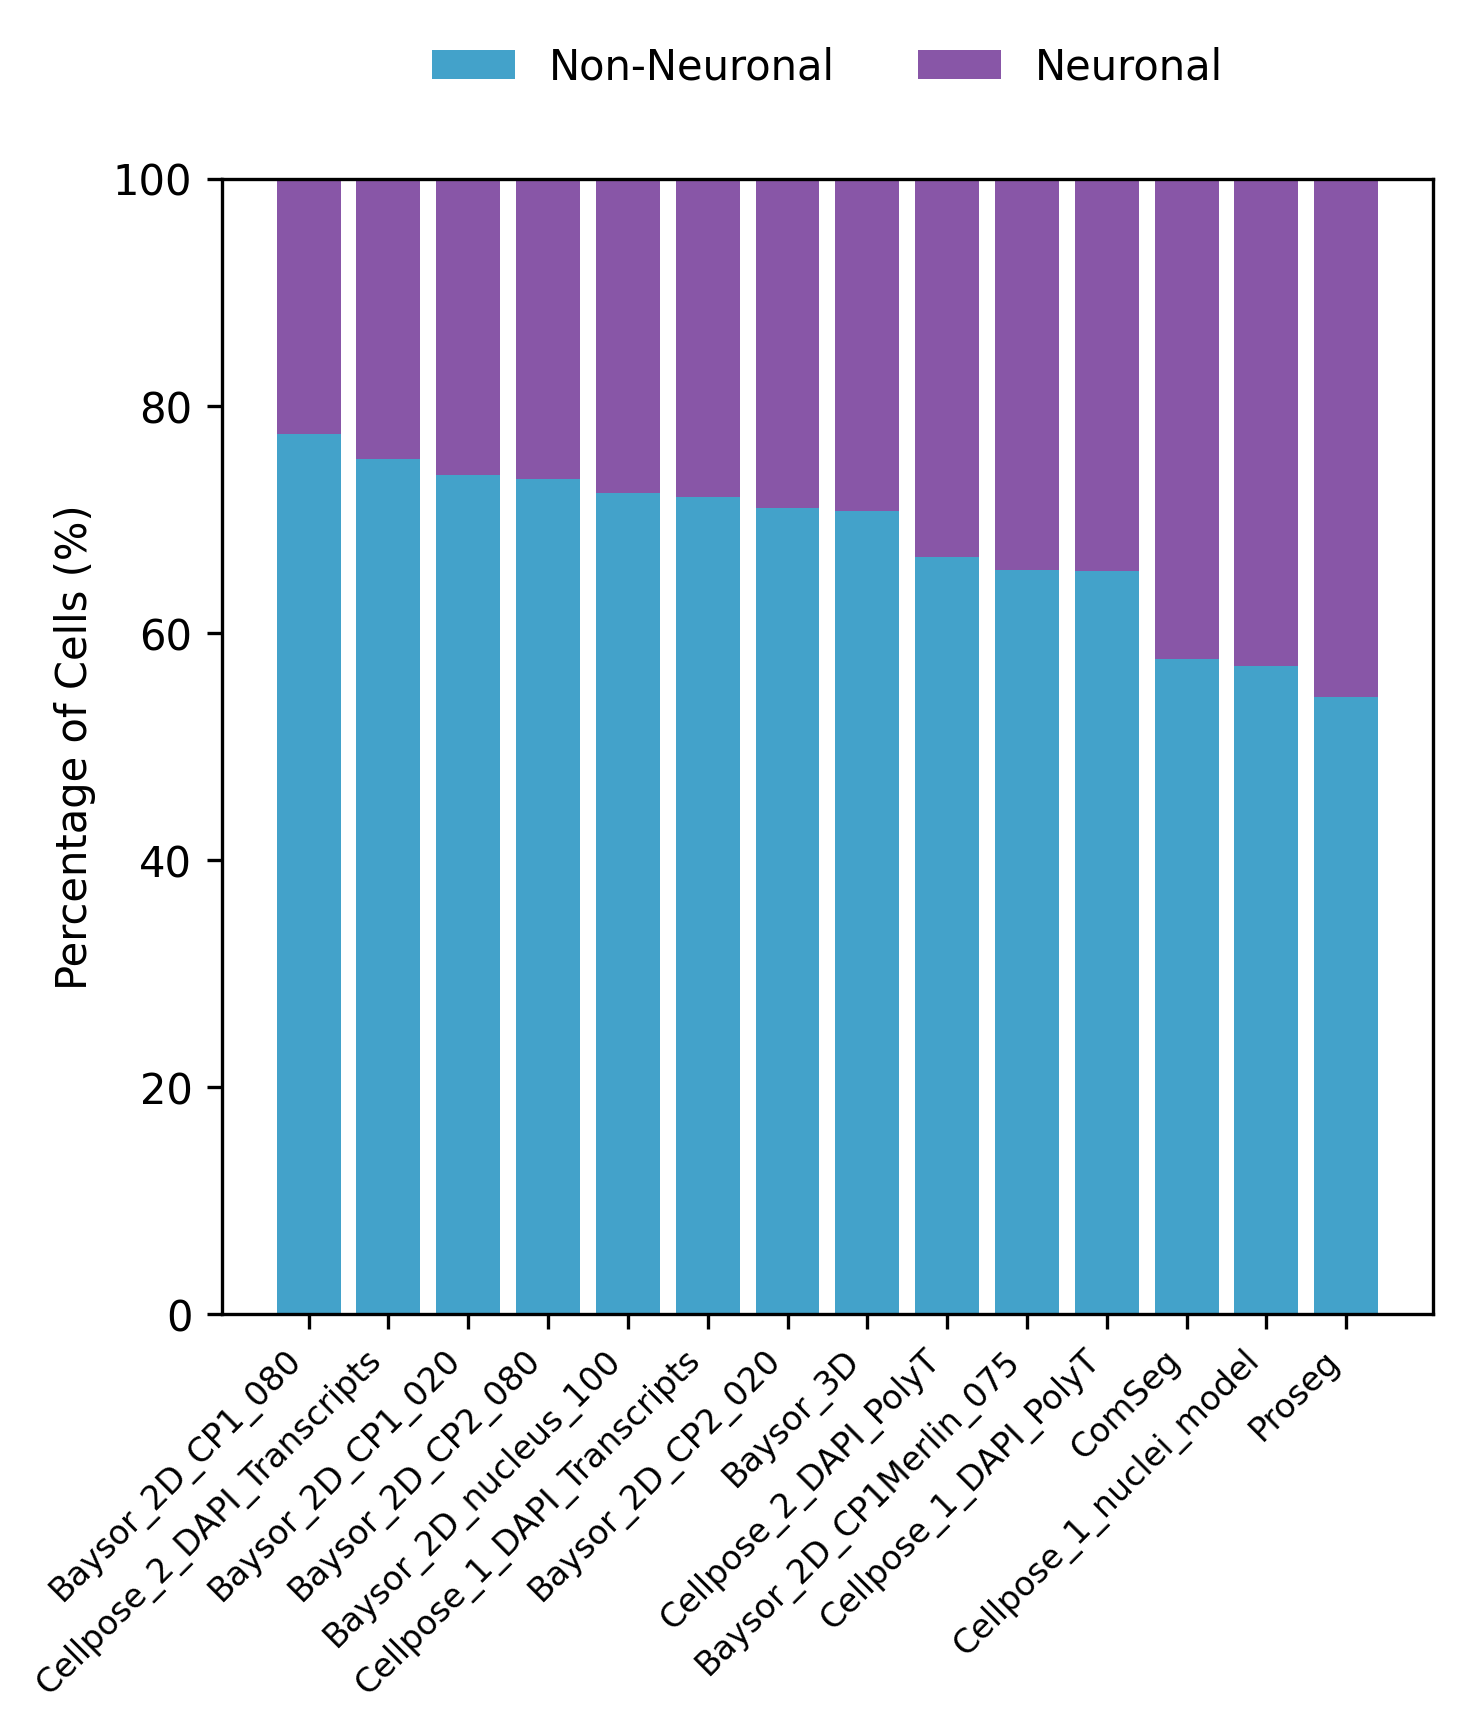

In [245]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define cell type groupings
neuronal_cells = [
    "Neurons-Glut",
    "Neurons-Immature",
    "Neurons-Gaba",
    "Neurons-Other",
    "Neurons-Dopa",
]
non_neuronal_cells = [
    "Oligodendrocytes",
    "Astrocytes",
    "Undefined",
    "ECs",
    "Microglia",
    "OPCs",
    "Pericytes",
    "VLMCs",
    "SMCs",
    "Choroid Plexus",
]

# Extract cell counts into a DataFrame, excluding negative controls
data = {}
for dataset, counts in distributions.items():
    # Clean dataset name
    clean_name = dataset.replace("adata_", "")

    # Skip negative controls
    if clean_name.startswith("Negative_Control"):
        continue

    # Calculate total counts for each group
    neuronal_count = sum(counts.get(cell, 0) for cell in neuronal_cells)
    non_neuronal_count = sum(counts.get(cell, 0) for cell in non_neuronal_cells)

    total_count = neuronal_count + non_neuronal_count

    # Calculate percentages
    if total_count > 0:
        neuronal_pct = (neuronal_count / total_count) * 100
        non_neuronal_pct = (non_neuronal_count / total_count) * 100
    else:
        neuronal_pct = 0
        non_neuronal_pct = 0

    data[clean_name] = {"Neuronal": neuronal_pct, "Non-Neuronal": non_neuronal_pct}

# Create DataFrame and sort by descending non-neuronal percentage
df = pd.DataFrame(data).T
df = df.sort_values(by="Non-Neuronal", ascending=False)

# Plot setup
fig, ax = plt.subplots(figsize=(5, 6), dpi=300)
x = np.arange(len(df))

# Create stacked bar plot
bottom = np.zeros(len(df))
colors = {"Neuronal": "#8856a7", "Non-Neuronal": "#43a2ca"}

for cell_group in ["Non-Neuronal", "Neuronal"]:  # Order matters for stacking
    ax.bar(x, df[cell_group], bottom=bottom, label=cell_group, color=colors[cell_group])
    bottom += df[cell_group]

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Percentage of Cells (%)")
ax.set_ylim(0, 100)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

## DAPI and PolyT brightness

In [11]:
# is in adata.obsm["intensities"] from sopa output

In [12]:
key = "adata_ComSeg"
sdata[key].obsm["intensities"].head()

,PolyT,DAPI,Transcripts
aaaaaaaa-1,3584.420136,3865.804238,355.459734
aaaaaaab-1,2939.327673,2519.248283,221.012101
aaaaaaac-1,3446.787759,3393.730878,382.322370
aaaaaaad-1,4345.015059,4852.861046,483.246945
aaaaaaae-1,3680.477119,4054.403424,346.531073


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def plot_intensity_violins(
    sdata, channels=["DAPI", "PolyT"], skip_datasets=None, color_dict=None
):
    """
    Create violin plots for specified channels from spatial data intensities.

    Parameters:
    -----------
    sdata : SpatialData object
        The spatial data object containing multiple datasets
    channels : list
        List of channel names to plot
    skip_datasets : list
        List of dataset names to skip
    color_dict : dict
        Dictionary mapping dataset names to colors
    """
    # Initialize skip_datasets if None
    if skip_datasets is None:
        skip_datasets = ["adata_Cellpose_1_Merlin", "adata_Proseg"]

    # Create a dataframe to store all intensities data
    all_data = []

    # Extract data from each dataset in sdata
    for name, table in sdata.tables.items():
        if name.startswith("adata_") and name not in skip_datasets:
            original_key = name.replace("adata_", "")

            # Create display name with replacements
            display_name = original_key
            display_name = (
                display_name.replace("Negative_Control_", "")
                .replace("Transcripts", "Transc")
                .replace("Baysor", "Bay")
                .replace("Cellpose", "CP")
                .replace("nuclei", "nuc")
                .replace("nucleus", "nuc")
                .replace("Merlin", "Mer")
            )

            # Get intensities data if available
            if "intensities" not in table.obsm:
                print(
                    f"Dataset {display_name} doesn't have .obsm['intensities']. Skipping."
                )
                continue

            intensities = table.obsm["intensities"]

            # For each requested channel
            for channel in channels:
                if channel in intensities.columns:
                    # Extract non-outlier cells
                    mask = (
                        ~table.obs["cell_outlier"]
                        if "cell_outlier" in table.obs.columns
                        else slice(None)
                    )

                    # Get channel values and create dataframe
                    values = intensities.loc[mask, channel]
                    df = pd.DataFrame(
                        {
                            "dataset": display_name,
                            "original_key": original_key,
                            "channel": channel,
                            "value": values,
                        }
                    )
                    all_data.append(df)

    if not all_data:
        raise ValueError("No intensity data found for the specified channels")

    plot_df = pd.concat(all_data, ignore_index=True)

    for channel in channels:
        channel_df = plot_df[plot_df["channel"] == channel]

        if len(channel_df) == 0:
            print(f"No data for channel {channel}")
            continue

        threshold = np.percentile(channel_df["value"], 99)
        filtered_df = channel_df[channel_df["value"] <= threshold]

        # Order by median value using display names
        dataset_order = (
            filtered_df.groupby("dataset")["value"].median().sort_values().index
        )

        plt.figure(figsize=(4, 6), dpi=300)
        plt.grid(True, alpha=0.3, zorder=0)

        if color_dict is not None:
            # Create mapping from display dataset names to colors based on original_key
            palette = {}
            for dataset, orig_key in (
                filtered_df[["dataset", "original_key"]].drop_duplicates().values
            ):
                if orig_key in color_dict:
                    palette[dataset] = color_dict[orig_key]
                else:
                    palette[dataset] = "#999999"  # Default color if not in color_dict
        else:
            palette = None

        sns.violinplot(
            x="value",
            y="dataset",
            data=filtered_df,
            hue="dataset",
            legend=False,
            palette=palette,
            inner="quartile",
            order=dataset_order,
            linewidth=0.7,
            zorder=2,
        )
        plt.yticks(rotation=0, va="top")
        plt.ylabel("")
        plt.xlabel(f"{channel} Intensity")
        plt.tight_layout()
        plt.show()

In [16]:
with open(
    os.path.join(
        data_dir, "samples", sample_name, "results", "metrics", "method_colors.json"
    ),
    "r",
) as f:
    color_map = json.load(f)
color_map

{'Baysor_2D_CP1Merlin_075': '#3366CC',
 'Baysor_2D_CP1_020': '#FF9900',
 'Baysor_2D_CP1_080': '#33CC33',
 'Baysor_2D_CP2_020': '#E31A1C',
 'Baysor_2D_CP2_080': '#9933CC',
 'Baysor_2D_nucleus_100': '#996633',
 'Baysor_3D': '#FF66B2',
 'Cellpose_1_DAPI_PolyT': '#666666',
 'Cellpose_1_DAPI_Transcripts': '#CCCC00',
 'Cellpose_1_nuclei_model': '#00CCCC',
 'Cellpose_2_DAPI_PolyT': '#003366',
 'Cellpose_2_DAPI_Transcripts': '#FF6600',
 'ComSeg': '#339900',
 'Ficture': '#CC0000',
 'Negative_Control_Rastered_10': '#800080',
 'Negative_Control_Rastered_25': '#8B4513',
 'Negative_Control_Rastered_5': '#FF1493',
 'Negative_Control_Voronoi': '#A9A9A9',
 'Proseg': '#20B2AA',
 'Cellpose_1_Merlin': '#FFD700'}

In [ ]:
plot_intensity_violins(
    sdata,
    channels=["DAPI", "PolyT"],
    skip_datasets=["adata_Cellpose_1_Merlin", "adata_Proseg"],
    color_dict=color_map,
)

## Marker FPR / specificity

In [141]:
adata = sdata["adata_Cellpose_2_DAPI_PolyT"]

In [142]:
adata.layers

Layers with keys: 

In [ ]:
# def scanpy_volume_log_norm(adata, volume_key, target_sum=250, layer_norm_name="volume_norm", layer_log_name="volume_log1p_norm"):
# tbc


In [ ]:
# adata, volume_key, target_sum=250, layer_norm_name="volume_norm", layer_log_name="volume_log1p_norm"):
# tbc

In [ ]:
# scanpy_volume_log_norm(adata)

In [ ]:
sdata["table"].layers["counts"] = sdata["table"].X

In [179]:
sdata["table"].layers

Layers with keys: counts, librarysize_log1p_norm

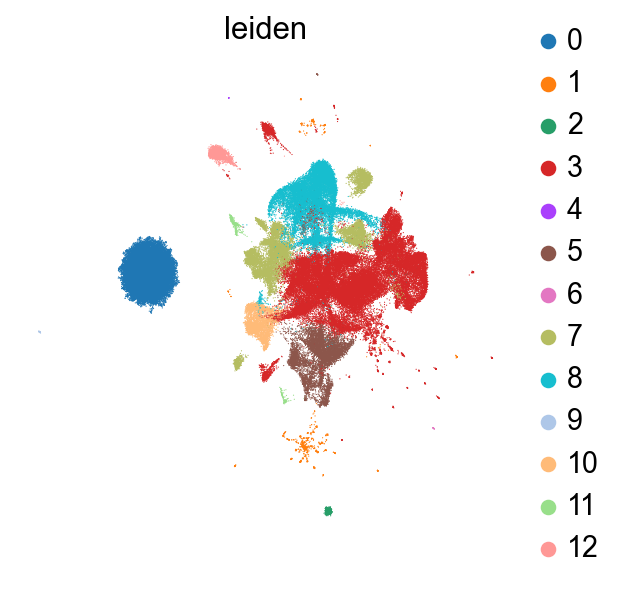

In [180]:
sc.tl.leiden(sdata["table"], flavor="igraph", resolution=0.1)
sc.pl.umap(sdata["table"], color=["leiden"])

In [181]:
# Generate random simulated cell type labels
random_labels = np.random.choice(
    [f"Group_{i + 1}" for i in range(13)], size=sdata["table"].obs.shape[0]
)
sdata["table"].obs["random_label"] = random_labels

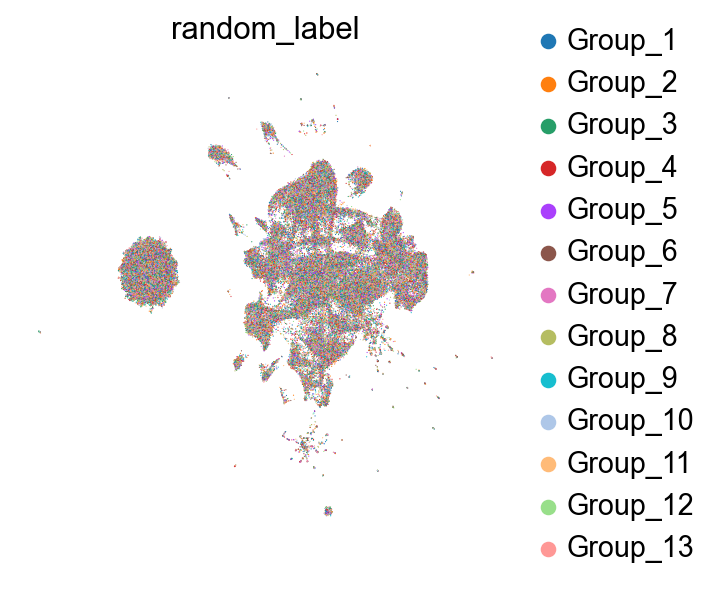

In [182]:
sc.pl.umap(sdata["table"], color=["random_label"])

In [335]:
target_marker = "Cldn5"

In [286]:
target_marker = "Tagln"

In [380]:
import metrics.specificity

In [383]:
x = metrics.specificity.calculate_marker_specificity_sensitivity(
    adata=sdata["table"], target_marker="Cldn5", groupby="leiden", target_cluster="5"
)

In [384]:
x

{'marker': 'Cldn5',
 'group': 'leiden',
 'target_cluster': '5',
 'expression_threshold': 0,
 'metrics': {'FPR': 0.058,
  'specificity': 0.942,
  'sensitivity': 0.782,
  'PPV': 0.505,
  'NPV': 0.983}}

In [385]:
x = metrics.specificity.calculate_marker_specificity_sensitivity(
    adata=sdata["table"],
    target_marker="Cldn5",
    groupby="random_label",
    target_cluster="Group_10",
)

In [386]:
x

{'marker': 'Cldn5',
 'group': 'random_label',
 'target_cluster': 'Group_10',
 'expression_threshold': 0,
 'metrics': {'FPR': 0.109,
  'specificity': 0.891,
  'sensitivity': 0.106,
  'PPV': 0.074,
  'NPV': 0.924}}

In [ ]:
# key metrics: FPR and sensitivity

## Marker enrichment

Todo: Use sum of transcripts per group to be able to be compatible with FICTURE

Proportion of transcripts in expected cluster vs. other clusters  
Effectively == FC


In [388]:
sc.tl.rank_genes_groups(sdata["table"], group="5", groupby="leiden", method="wilcoxon")

In [400]:
rank = sc.get.rank_genes_groups_df(sdata["table"], group="5")
rank

,names,scores,logfoldchanges,pvals,pvals_adj
0,Flt1,120.588974,11.408150,0.000000e+00,0.000000e+00
1,Epas1,117.150620,15.165833,0.000000e+00,0.000000e+00
2,Eng,114.533363,9.336301,0.000000e+00,0.000000e+00
3,Rgs5,111.468399,17.904018,0.000000e+00,0.000000e+00
4,Abcb1a,111.294403,10.169430,0.000000e+00,0.000000e+00
...,...,...,...,...,...
495,Ptprd,-23.557770,-2.160015,1.045076e-122,3.786506e-122
496,Slc7a14,-24.850861,-3.454920,2.531052e-136,9.587317e-136
497,Mog,-25.110411,-2.389013,3.827910e-139,1.461035e-138
498,Slc4a10,-27.528532,-4.304514,7.999014e-167,3.278284e-166


In [405]:
np.exp(rank["logfoldchanges"])  # FC

0      9.005265e+04
1      3.858671e+06
2      1.134237e+04
3      5.965082e+07
4      2.609319e+04
           ...     
495    1.153234e-01
496    3.158984e-02
497    9.172014e-02
498    1.350744e-02
499    8.768668e-03
Name: logfoldchanges, Length: 500, dtype: float32

## Compare marker distributions  
Within and outside of targer cluster

Todo: Use specific known marker

Todo: Dendent on normaloizatin?

In [535]:
import metrics.wasserstein

In [536]:
y = metrics.wasserstein.calculate_wasserstein_distance(
    adata=sdata["table"],
    target_cluster="5",
    groupby="leiden",
    layer="librarysize_log1p_norm",
)

In [537]:
y

,gene,distance
0,Rgs5,1.801509
1,Epas1,1.703756
2,Cldn5,1.634957
3,Flt1,1.623037
4,Abcb1a,1.415774
...,...,...
495,Casz1,0.005500
496,Pifo,0.004543
497,Folr1,0.003865
498,Dll3,0.003619


In [ ]:
# plot selected genes

In [444]:
target_marker = "Flt1"

In [521]:
target_marker = "Rgs5"

In [522]:
groupby = "leiden"
target_cluster = "5"
layer = "librarysize_log1p_norm"

In [525]:
adata = sdata["table"]
adata.X = adata.layers[layer]
target_marker_adata = adata[:, adata.var_names.str.match(target_marker)]
cells_cluster = adata[adata.obs[groupby] == target_cluster].obs_names
cells_other = adata[adata.obs[groupby] != target_cluster].obs_names
adata_cluster = target_marker_adata[cells_cluster]
adata_other = target_marker_adata[cells_other]

<Axes: ylabel='Count'>

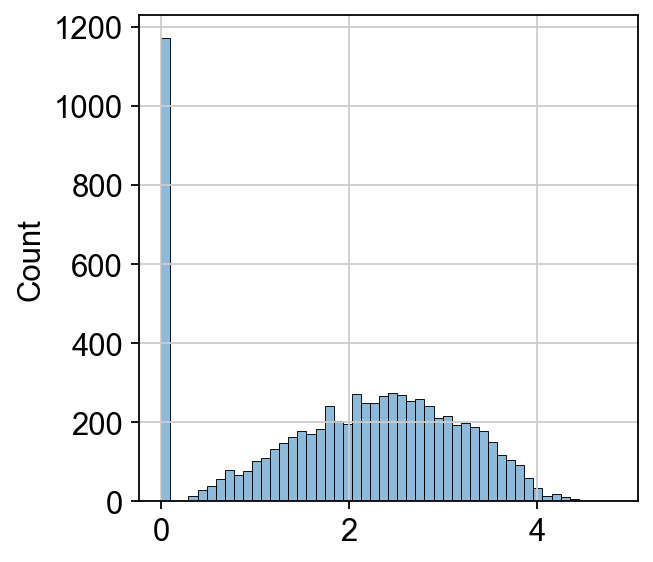

In [530]:
sns.histplot(adata_cluster.X, bins=50, legend=False)

<Axes: ylabel='Count'>

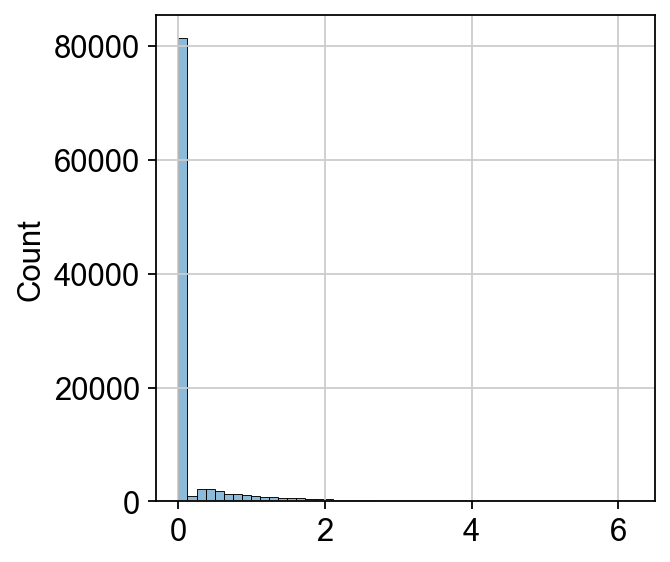

In [531]:
sns.histplot(adata_other.X, bins=50, legend=False)